In [1]:
from lightgbm import plot_importance, plot_metric, plot_split_value_histogram, create_tree_digraph, plot_tree
from lightgbm import LGBMClassifier, LGBMRegressor

from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance as xplot_importance

from scipy import interp
from itertools import cycle

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

In [2]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [3]:
#data_path = './data_tesis_final_lect_mate.csv'
data_path = './data.csv'
df = pd.read_csv(data_path, sep=";")

In [4]:
len_data_init = len(df)
len_data_init

267769

### LIMPIEZA DE DATOS

In [5]:
df = df.drop(columns=['_id', 'agno', 'cod_curso', 'idalumno', 'mrun'])

In [6]:
df = df.drop(columns=['cod_com_alu_2018', 'cod_com_alu_2017', 'cod_com_alu_2016', 'cod_com_alu_2015', 'cod_com_alu_2014', 'cod_com_alu_2013'])
df = df.drop(columns=['cod_com_rbd_2018', 'cod_com_rbd_2017', 'cod_com_rbd_2016', 'cod_com_rbd_2015', 'cod_com_rbd_2014', 'cod_com_rbd_2013'])
df = df.drop(columns=['cod_reg_alu_2014', 'cod_reg_alu_2013'])
df = df.drop(columns=['cod_reg_rbd_2014', 'cod_reg_rbd_2013'])
df = df.drop(columns=['criterio_sep_2013', 'criterio_sep_2014'])
df = df.drop(columns=['grado_sep_2013', 'grado_sep_2014'])
df = df.drop(columns=['preferente_2013', 'preferente_2014'])
df = df.drop(columns=['prioritario_2013', 'prioritario_2014'])
df = df.drop(columns=['ben_sep_2013', 'ben_sep_2014'])
df = df.drop(columns=['cod_depe_2018', 'cod_depe_2017', 'cod_depe_2016', 'cod_depe_2015', 'cod_depe_2014'])

In [7]:
#df = df[df['ptje_mate'] > 0]
df = df.dropna(subset=['cpad_p10'])
df = df.dropna(subset=['cprof_p01'])
df = df.dropna(subset=['cest_p03_01'])
df = df.dropna(subset=['prom_gral_2018'])

df = df[df['cd_rbd_2018'] != "SIN CATEGORIA: BAJA MATRICULA"]
df = df[df['cd_rbd_2018'] != "SIN CATEGORIA: FALTA DE INFORMACIÓN"]
df['cd_rbd_2018'].replace({"MEDIO-BAJO (NUEVO)": "MEDIO-BAJO"}, inplace=True)
df = df.dropna(subset=['cd_rbd_2018'])

df = df[df['cd_rbd_2017'] != "SIN CATEGORIA: BAJA MATRICULA"]
df = df[df['cd_rbd_2017'] != "SIN CATEGORIA: FALTA DE INFORMACIÓN"]
df['cd_rbd_2017'].replace({"MEDIO-BAJO (NUEVO)": "MEDIO-BAJO"}, inplace=True)
df = df.dropna(subset=['cd_rbd_2017'])

df = df[df['cd_rbd_2016'] != "SIN CATEGORIA: BAJA MATRICULA"]
df = df[df['cd_rbd_2016'] != "SIN CATEGORIA: FALTA DE INFORMACIÓN"]
df['cd_rbd_2016'].replace({"MEDIO-BAJO (NUEVO)": "MEDIO-BAJO"}, inplace=True)
df = df.dropna(subset=['cd_rbd_2017'])

df = df[df['cd_alu_2018'] != "SIN CATEGORIA: BAJA MATRICULA"]
df = df[df['cd_alu_2018'] != "SIN CATEGORIA: FALTA DE INFORMACIÓN"]
df['cd_alu_2018'].replace({"MEDIO-BAJO (NUEVO)": "MEDIO-BAJO"}, inplace=True)
df = df.dropna(subset=['cd_alu_2018'])

df = df[df['cd_alu_2017'] != "SIN CATEGORIA: BAJA MATRICULA"]
df = df[df['cd_alu_2017'] != "SIN CATEGORIA: FALTA DE INFORMACIÓN"]
df['cd_alu_2017'].replace({"MEDIO-BAJO (NUEVO)": "MEDIO-BAJO"}, inplace=True)
df = df.dropna(subset=['cd_rbd_2017'])

df = df[df['cd_alu_2016'] != "SIN CATEGORIA: BAJA MATRICULA"]
df = df[df['cd_alu_2016'] != "SIN CATEGORIA: FALTA DE INFORMACIÓN"]
df['cd_alu_2016'].replace({"MEDIO-BAJO (NUEVO)": "MEDIO-BAJO"}, inplace=True)
df = df.dropna(subset=['cd_alu_2017'])

df['gen_alu'].replace({2: 0}, inplace=True)

df['preferente_2015'].fillna(0, inplace=True)
df['preferente_2016'].fillna(0, inplace=True)
df['preferente_2017'].fillna(0, inplace=True)
df['preferente_2018'].fillna(0, inplace=True)

df['prioritario_2015'].fillna(0, inplace=True)
df['prioritario_2016'].fillna(0, inplace=True)
df['prioritario_2017'].fillna(0, inplace=True)
df['prioritario_2018'].fillna(0, inplace=True)

df['grado_sep_2015'].fillna(0, inplace=True)
df['grado_sep_2016'].fillna(0, inplace=True)
df['grado_sep_2017'].fillna(0, inplace=True)
df['grado_sep_2018'].fillna(0, inplace=True)

df['ben_sep_2015'].fillna(0, inplace=True)
df['ben_sep_2016'].fillna(0, inplace=True)
df['ben_sep_2017'].fillna(0, inplace=True)
df['ben_sep_2018'].fillna(0, inplace=True)

df['criterio_sep_2015'].fillna(0, inplace=True)
df['criterio_sep_2016'].fillna(0, inplace=True)
df['criterio_sep_2017'].fillna(0, inplace=True)
df['criterio_sep_2018'].fillna(0, inplace=True)

df = df[df['cod_grado_2018'] == 4]
df = df[(df['cod_grado_2017'] <= 4) | (df['cod_grado_2017'] == np.nan)]
df = df[(df['cod_grado_2016'] <= 4) | (df['cod_grado_2016'] == np.nan)]
df = df[(df['cod_grado_2015'] <= 4) | (df['cod_grado_2015'] == np.nan)]

df = df.drop(columns=['asistencia_2013', 'asistencia_2014'])
df = df.drop(columns=['prom_gral_2013', 'prom_gral_2014'])
df = df.drop(columns=['rbd_2013', 'rbd_2014'])
df = df.drop(columns=['rural_rbd_2013', 'rural_rbd_2014'])

df = df.drop(columns=['cod_grado_2013'])
df = df.drop(columns=['cod_depe_2013', 'cod_depe2_2014'])


df = df.drop(columns=['ind_am_alu_2014', 'ind_am_rbd_2014', 'ind_cc_alu_2014', 'ind_cc_rbd_2014', 'ind_hv_alu_2014', 'ind_hv_rbd_2014', 'ind_pf_alu_2014', 'ind_pf_rbd_2014'])
df = df.drop(columns=['ind_am_rbd_2015', 'ind_am_rbd_2016', 'ind_am_rbd_2017', 'ind_am_rbd_2018'])
df = df.drop(columns=['ind_cc_rbd_2015', 'ind_cc_rbd_2016', 'ind_cc_rbd_2017', 'ind_cc_rbd_2018'])
df = df.drop(columns=['ind_hv_rbd_2015', 'ind_hv_rbd_2016', 'ind_hv_rbd_2017', 'ind_hv_rbd_2018'])
df = df.drop(columns=['ind_pf_rbd_2015', 'ind_pf_rbd_2016', 'ind_pf_rbd_2017', 'ind_pf_rbd_2018'])
df = df.drop(columns=['rural_rbd_2018', 'rural_rbd_2017', 'rural_rbd_2016', 'rural_rbd_2015'])
df = df.drop(columns=['rbd_2018', 'rbd_2017', 'rbd_2016', 'rbd_2015', 'rbd'])
df = df.drop(columns=['cd_rbd_2018', 'cd_rbd_2017', 'cd_rbd_2016'])

In [8]:
print("Columns with nan's values")
for colum in df.columns:
    if(df[colum].isna().sum()):
        print(colum," == ",df[colum].isna().sum(), " ==== ",df[colum].dtype)

Columns with nan's values
cd_alu_2016  ==  932  ====  object
cod_grado_2014  ==  166096  ====  float64
ind_am_alu_2015  ==  1637  ====  float64
ind_am_alu_2016  ==  1097  ====  float64
ind_am_alu_2017  ==  222  ====  float64
ind_am_alu_2018  ==  15  ====  float64
ind_cc_alu_2015  ==  5322  ====  float64
ind_cc_alu_2016  ==  7833  ====  float64
ind_cc_alu_2017  ==  3762  ====  float64
ind_cc_alu_2018  ==  110  ====  float64
ind_hv_alu_2015  ==  1637  ====  float64
ind_hv_alu_2016  ==  1105  ====  float64
ind_hv_alu_2017  ==  222  ====  float64
ind_hv_alu_2018  ==  23  ====  float64
ind_pf_alu_2015  ==  2101  ====  float64
ind_pf_alu_2016  ==  1290  ====  float64
ind_pf_alu_2017  ==  222  ====  float64
ind_pf_alu_2018  ==  15  ====  float64


In [9]:
##ind_pf_alu_*
search_colums="ind_pf_alu_"
features = [ f for f in list(df) if search_colums in f ]
for f in features:
    print(f," == ",df[f].isna().sum())
    df[f].fillna(df[features].mean(axis=1),inplace=True)
    print(f," == ",df[f].isna().sum())
    print("="*32)

ind_pf_alu_2015  ==  2101
ind_pf_alu_2015  ==  0
ind_pf_alu_2016  ==  1290
ind_pf_alu_2016  ==  0
ind_pf_alu_2017  ==  222
ind_pf_alu_2017  ==  0
ind_pf_alu_2018  ==  15
ind_pf_alu_2018  ==  0


In [10]:
##ind_cc_alu_*
search_colums="ind_cc_alu_"
features = [ f for f in list(df) if search_colums in f ]
for f in features:
    print(f," == ",df[f].isna().sum())
    df[f].fillna(df[features].mean(axis=1),inplace=True)
    print(f," == ",df[f].isna().sum())
    print("="*32)

ind_cc_alu_2015  ==  5322
ind_cc_alu_2015  ==  0
ind_cc_alu_2016  ==  7833
ind_cc_alu_2016  ==  0
ind_cc_alu_2017  ==  3762
ind_cc_alu_2017  ==  0
ind_cc_alu_2018  ==  110
ind_cc_alu_2018  ==  0


In [11]:
##ind_hv_alu_*
search_colums="ind_hv_alu_"
features = [ f for f in list(df) if search_colums in f ]
for f in features:
    print(f," == ",df[f].isna().sum())
    df[f].fillna(df[features].mean(axis=1),inplace=True)
    print(f," == ",df[f].isna().sum())
    print("="*32)

ind_hv_alu_2015  ==  1637
ind_hv_alu_2015  ==  0
ind_hv_alu_2016  ==  1105
ind_hv_alu_2016  ==  0
ind_hv_alu_2017  ==  222
ind_hv_alu_2017  ==  0
ind_hv_alu_2018  ==  23
ind_hv_alu_2018  ==  0


In [12]:
##ind_am_alu_*
search_colums="ind_am_alu_"
features = [ f for f in list(df) if search_colums in f ]
for f in features:
    print(f," == ",df[f].isna().sum())
    df[f].fillna(df[features].mean(axis=1),inplace=True)
    print(f," == ",df[f].isna().sum())
    print("="*32)

ind_am_alu_2015  ==  1637
ind_am_alu_2015  ==  0
ind_am_alu_2016  ==  1097
ind_am_alu_2016  ==  0
ind_am_alu_2017  ==  222
ind_am_alu_2017  ==  0
ind_am_alu_2018  ==  15
ind_am_alu_2018  ==  0


In [13]:
#Crear repitencia y borrar variables de grado.
features = [ f for f in list(df) if 'cod_grado' in f ]
for f in features:
    df[f] = df[f].astype(str)
df['cod_grados'] = df['cod_grado_2018'] +"-"+ df['cod_grado_2017'] +"-"+ df['cod_grado_2016'] +"-"+ df['cod_grado_2015'] +"-"+ df['cod_grado_2014']
df['repitencia'] = np.where(df['cod_grados'] ==  "4.0-3.0-2.0-1.0-nan", 0, 1)
features.append('cod_grados')
df = df.drop(columns=features)

In [14]:
print("Columns with nan's values")
for colum in df.columns:
    if(df[colum].isna().sum()):
        print(colum," == ",df[colum].isna().sum(), " ==== ",df[colum].dtype)

Columns with nan's values
cd_alu_2016  ==  932  ====  object


In [15]:
#Calidad de desempeño => Eliminar alumnos que no cuentan con categoria en el año 2016
df.dropna(inplace=True)

In [16]:
#ETNIA
df['etnia'] = 0
df['etnia'] = np.where((df['cpad_p08_01'] == "1.0") | (df['cpad_p08_02'] == "1.0") | (df['cpad_p08_03'] == "1.0"), 1,0)

In [17]:
len_data_post_proce = len(df)
len_data_post_proce 

180172

In [18]:
len_data_post_proce/len_data_init

0.6728635502989517

In [19]:
df = df[(df['cprof_p09_01'] > 0) & (df['cprof_p09_01'] <= 44)]
df = df[(df['cprof_p09_02'] >= 0) & (df['cprof_p09_02'] <= 15)]
df = df[(df['cprof_p09_03'] >= 0) & (df['cprof_p09_03'] <= 30)]
df = df[(df['cprof_p02'] >= 20) & (df['cprof_p02'] <= 90)]

In [20]:
len_data_post_proce2 = len(df)
len_data_post_proce2 

147840

In [21]:
len_data_post_proce2/len_data_init

0.5521176835257255

In [22]:
len_data_post_proce3 = len(df)
len_data_post_proce3 

147840

In [23]:
len_data_post_proce3/len_data_init

0.5521176835257255

In [24]:
def plot_roc_auc(probs, y_test, save=0, name="none"):
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, 'b', label = 'Área = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    if(save):
        plt.savefig(name+'.pdf') 
    plt.show()

In [25]:
def plot_roc_auc_scores(n_classes, preds, test, save=0, name="none", target_name='ptje_mate'):
    y_score = preds
    y_test = pd.get_dummies(test, columns=[target_name]).to_numpy()

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average Curva ROC (área = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average Curva ROC (área = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Curva ROC de la clase {0} (área = {1:0.2f})'
                 ''.format(target_names[i], roc_auc[i]))
    
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc="lower right")
    if(save):
        plt.savefig(name+'.pdf') 
    plt.show()

## CONFIG DATA

In [26]:
#Config
#Version: 1 = 3 Categorias 'Insuficiente', 'Elemental', 'Adecuado'
#Version: 2 = 2 Categorias 'Insuficiente', 'Adecuado'
#Version: 3 = 2 Categorias 'Insuficiente/Elemental', 'Adecuado'
#Version: 4 = 2 Categorias 'Insuficiente', 'Elemental/Adecuado'
#Version: 5 = 2 Categorias 'Insuficiente/Elemental', 'Elemental/Adecuado'
version = 2

#ptje_target = "ptje_lect"
ptje_target = "ptje_mate"


#Selected data: 1 = Solo indices
#Selected data: 2 = Todas las variables excepción de indices, notas y asistencia
#Selected data: 3 = Todas las variables sin excepción
#Selected data: 4 = Todas las variables excepción de indices


"======================================================="

#Selected data 1 = Solo indices
#Selected data 2 = Variables academicas profesores, alumnos, 
#Selected data 3 = Socioeconomicas, indices, clasificación sep, padres, colegio
#
#Selected data: 5 = Todos los datos
# Las mejores variables

selected_data = -3

In [27]:
print(len(df))
df = df[df['prom_gral_2017'] > 0]
df = df[df['prom_gral_2016'] > 0]
df = df[df['prom_gral_2015'] > 0]
print(len(df))
print(len(df)/len_data_init)

147840
135258
0.5051294212548876


In [36]:
def getData(data_index):
    if(data_index == 1):
        binary_features_df = []

        categorical_features_df = [
            "cd_alu_2018","cd_alu_2017","cd_alu_2016"
        ]

        numerical_features_df = ["ind_am_alu_2015","ind_am_alu_2016","ind_am_alu_2017","ind_am_alu_2018",
                                 "ind_cc_alu_2015","ind_cc_alu_2016","ind_cc_alu_2017","ind_cc_alu_2018",
                                 "ind_hv_alu_2015","ind_hv_alu_2016","ind_hv_alu_2017","ind_hv_alu_2018",
                                 "ind_pf_alu_2015","ind_pf_alu_2016","ind_pf_alu_2017","ind_pf_alu_2018"]

        for cdf in categorical_features_df:
            df[cdf] = df[cdf].astype(str)

        data = df[[ptje_target]+numerical_features_df+binary_features_df+categorical_features_df]

    elif(data_index == 2):
        binary_features_df = [
            "cest_p08_01","cest_p08_02","cest_p08_03","cest_p08_04","cest_p08_05","cest_p08_06",
            "cprof_p01","cprof_p03_01","cprof_p03_02","cprof_p03_03","cprof_p03_04",
            "cprof_p04_01","cprof_p04_02","cprof_p04_03","cprof_p04_04","cprof_p04_05","cprof_p04_06",
            "cprof_p04_07","cprof_p04_08","cprof_p04_09","cprof_p04_10","cprof_p04_11","cprof_p04_12","cprof_p04_13",
            "cprof_p05",
            "cprof_p06_01","cprof_p06_02","cprof_p06_03","cprof_p06_04","cprof_p06_05","cprof_p06_06",
            "cprof_p07_02","cprof_p07_04",
            "cprof_p10_01","cprof_p10_02","cprof_p10_03","cprof_p10_04","cprof_p10_05","cprof_p10_06","cprof_p10_07",
            "cprof_p10_08","cprof_p10_09","repitencia"
        ]

        categorical_features_df = [
            "cest_p04_07",
            "cest_p05_01","cest_p05_02",
            "cest_p06_01","cest_p06_02","cest_p06_03","cest_p06_04","cest_p06_05","cest_p06_06",
            "cest_p07_01","cest_p07_02","cest_p07_03",
            "cest_p09_01","cest_p09_02","cest_p09_03","cest_p09_04",
            "cod_depe2_2018","cod_depe2_2017","cod_depe2_2016","cod_depe2_2015",
            "cod_grupo","cpad_p06","cpad_p07",
            "criterio_sep_2018","criterio_sep_2017","criterio_sep_2016","criterio_sep_2015" 
        ]

        numerical_features_df = ["cprof_p02",
                                 "cprof_p07_01","cprof_p07_03",
                                 "cprof_p09_01","cprof_p09_02","cprof_p09_03"]

        for cdf in categorical_features_df:
            df[cdf] = df[cdf].astype(str)

        data = df[[ptje_target]+numerical_features_df+binary_features_df+categorical_features_df]


    elif(data_index == 3):

        binary_features_df = [
            'gen_alu',
            'preferente_2015','preferente_2016','preferente_2017','preferente_2018',
            'prioritario_2015','prioritario_2016','prioritario_2017','prioritario_2018',
        ]

        categorical_features_df = [
            'cod_grupo',
            'cpad_p06','cpad_p07','cpad_p10'
        ]

        numerical_features_df = [
        ]

        data = df[[ptje_target]+numerical_features_df+binary_features_df+categorical_features_df]
        
    elif(data_index == 4):

        binary_features_df = [
            "etnia",
            'ben_sep_2015','ben_sep_2016','ben_sep_2017','ben_sep_2018',
            #'cprof_p03_01','cprof_p03_02','cprof_p03_03','cprof_p03_04',
            #'cprof_p04_01','cprof_p04_02','cprof_p04_03','cprof_p04_04','cprof_p04_05','cprof_p04_06',
            #'cprof_p04_07','cprof_p04_08','cprof_p04_09','cprof_p04_10','cprof_p04_11','cprof_p04_12',
            #'cprof_p04_13',
            #'cprof_p06_01','cprof_p06_02','cprof_p06_03','cprof_p06_04','cprof_p06_05','cprof_p06_06',
            #'cprof_p07_02','cprof_p07_04',
            #'cprof_p10_01','cprof_p10_02','cprof_p10_03','cprof_p10_04',
            #'cprof_p10_05','cprof_p10_06','cprof_p10_07','cprof_p10_08','cprof_p10_09',
            'gen_alu',
            #'grado_sep_2015','grado_sep_2016','grado_sep_2017','grado_sep_2018',
            'preferente_2015','preferente_2016','preferente_2017','preferente_2018',
            'prioritario_2015','prioritario_2016','prioritario_2017','prioritario_2018',
            'rural_rbd',
            #'tipo_prueba',
            'repitencia'
        ]

        categorical_features_df = [
            'cd_alu_2016','cd_alu_2017','cd_alu_2018',
            'cest_p03_01',
            #'cest_p03_02','cest_p03_03','cest_p03_04','cest_p03_05',
            #'cest_p04_01','cest_p04_02','cest_p04_03','cest_p04_04','cest_p04_05','cest_p04_06',
            'cest_p04_07',
            #'cest_p04_08',
            #'cest_p05_01','cest_p05_02',
            #'cest_p06_01','cest_p06_02','cest_p06_03','cest_p06_04','cest_p06_05','cest_p06_06',
            #'cest_p07_01','cest_p07_02','cest_p07_03',
            #'cest_p08_01','cest_p08_02','cest_p08_03','cest_p08_04','cest_p08_05','cest_p08_06',
            'cest_p09_01','cest_p09_02','cest_p09_03','cest_p09_04',
            'cod_depe2_2015','cod_depe2_2016','cod_depe2_2017','cod_depe2_2018',
            'cod_grupo',
            'cod_reg_alu_2015','cod_reg_alu_2016','cod_reg_alu_2017','cod_reg_alu_2018',
            #'cpad_p05',
            'cpad_p06','cpad_p07',
            #'cpad_p08_01','cpad_p08_02','cpad_p08_03',
            #'cpad_p09_01','cpad_p09_02','cpad_p09_03','cpad_p10',
            #'cprof_p01','cprof_p05',
            #'criterio_sep_2015','criterio_sep_2016','criterio_sep_2017','criterio_sep_2018' 
        ]

        numerical_features_df = [
            #'cprof_p02','cprof_p07_01','cprof_p07_03','cprof_p09_01','cprof_p09_02','cprof_p09_03',
            #'ind_am_alu_2015','ind_am_alu_2016','ind_am_alu_2017','ind_am_alu_2018',
            #'ind_cc_alu_2015','ind_cc_alu_2016','ind_cc_alu_2017',
            'ind_cc_alu_2018',
            #'ind_hv_alu_2015','ind_hv_alu_2016','ind_hv_alu_2017','ind_hv_alu_2018',
            #'ind_pf_alu_2015','ind_pf_alu_2016','ind_pf_alu_2017','ind_pf_alu_2018',
        ]

        data = df[[ptje_target]+numerical_features_df+binary_features_df+categorical_features_df]
        
    elif(data_index == 5):
        binary_features_df = [
            "etnia",
            'ben_sep_2015','ben_sep_2016','ben_sep_2017','ben_sep_2018',
            'cprof_p03_01','cprof_p03_02','cprof_p03_03','cprof_p03_04',
            'cprof_p04_01','cprof_p04_02','cprof_p04_03','cprof_p04_04','cprof_p04_05','cprof_p04_06',
            'cprof_p04_07','cprof_p04_08','cprof_p04_09','cprof_p04_10','cprof_p04_11','cprof_p04_12',
            'cprof_p04_13',
            'cprof_p06_01','cprof_p06_02','cprof_p06_03','cprof_p06_04','cprof_p06_05','cprof_p06_06',
            'cprof_p07_02','cprof_p07_04',
            'cprof_p10_01','cprof_p10_02','cprof_p10_03','cprof_p10_04',
            'cprof_p10_05','cprof_p10_06','cprof_p10_07','cprof_p10_08','cprof_p10_09',
            'gen_alu',
            'grado_sep_2015','grado_sep_2016','grado_sep_2017','grado_sep_2018',
            'rural_rbd','tipo_prueba','repitencia'
        ]

        categorical_features_df = [
            "cd_alu_2018","cd_alu_2017","cd_alu_2016",
            "cest_p03_01","cest_p03_02","cest_p03_03","cest_p03_04","cest_p03_05",
            "cest_p04_01","cest_p04_02","cest_p04_03","cest_p04_04","cest_p04_05","cest_p04_06","cest_p04_07","cest_p04_08",
            "cest_p05_01","cest_p05_02",
            "cest_p06_01","cest_p06_02","cest_p06_03","cest_p06_04","cest_p06_05","cest_p06_06",
            "cest_p07_01","cest_p07_02","cest_p07_03",
            "cest_p09_01","cest_p09_02","cest_p09_03","cest_p09_04",
            "cod_depe2_2018","cod_depe2_2017","cod_depe2_2016","cod_depe2_2015",
            "cod_grupo",
            "cod_reg_alu_2018","cod_reg_alu_2017","cod_reg_alu_2016","cod_reg_alu_2015",
            "cpad_p05","cpad_p06",
            "cpad_p07",
            "cpad_p08_01","cpad_p08_02","cpad_p08_03",
            "cpad_p09_01","cpad_p09_02","cpad_p09_03",
            "cpad_p10",
            "criterio_sep_2018","criterio_sep_2017","criterio_sep_2016","criterio_sep_2015"  
        ]

        numerical_features_df = ["cprof_p02",
                                 "cprof_p07_01","cprof_p07_03",
                                 "cprof_p09_01","cprof_p09_02","cprof_p09_03",
                                 'ind_am_alu_2015','ind_am_alu_2016','ind_am_alu_2017','ind_am_alu_2018',
                                 'ind_cc_alu_2015','ind_cc_alu_2016','ind_cc_alu_2017','ind_cc_alu_2018',
                                 'ind_hv_alu_2015','ind_hv_alu_2016','ind_hv_alu_2017','ind_hv_alu_2018',
                                 'ind_pf_alu_2015','ind_pf_alu_2016','ind_pf_alu_2017','ind_pf_alu_2018',
                                 'prom_gral_2015','prom_gral_2016','prom_gral_2017',
                                 'asistencia_2015', 'asistencia_2016', 'asistencia_2017']

        for cdf in categorical_features_df:
            df[cdf] = df[cdf].astype(str)

        data = df[[ptje_target]+numerical_features_df+binary_features_df+categorical_features_df]
    elif(data_index == 6):
        binary_features_df = [
            "etnia",
            'ben_sep_2015','ben_sep_2016','ben_sep_2017','ben_sep_2018',
            'cprof_p03_01','cprof_p03_02','cprof_p03_03','cprof_p03_04',
            'cprof_p04_01','cprof_p04_02','cprof_p04_03','cprof_p04_04','cprof_p04_05','cprof_p04_06',
            'cprof_p04_07','cprof_p04_08','cprof_p04_09','cprof_p04_10','cprof_p04_11','cprof_p04_12',
            'cprof_p04_13',
            'cprof_p06_01','cprof_p06_02','cprof_p06_03','cprof_p06_04','cprof_p06_05','cprof_p06_06',
            'cprof_p07_02','cprof_p07_04',
            'cprof_p10_01','cprof_p10_02','cprof_p10_03','cprof_p10_04',
            'cprof_p10_05','cprof_p10_06','cprof_p10_07','cprof_p10_08','cprof_p10_09',
            'gen_alu',
            'grado_sep_2015','grado_sep_2016','grado_sep_2017','grado_sep_2018',
            'preferente_2015','preferente_2016','preferente_2017','preferente_2018',
            'rural_rbd','tipo_prueba','repitencia'
        ]

        categorical_features_df = [
            "cd_alu_2018","cd_alu_2017","cd_alu_2016",
            "cest_p03_01","cest_p03_02","cest_p03_03","cest_p03_04","cest_p03_05",
            "cest_p04_01","cest_p04_02","cest_p04_03","cest_p04_04","cest_p04_05","cest_p04_06","cest_p04_07","cest_p04_08",
            "cest_p05_01","cest_p05_02",
            "cest_p06_01","cest_p06_02","cest_p06_03","cest_p06_04","cest_p06_05","cest_p06_06",
            "cest_p07_01","cest_p07_02","cest_p07_03",
            "cest_p09_01","cest_p09_02","cest_p09_03","cest_p09_04",
            "cod_depe2_2018","cod_depe2_2017","cod_depe2_2016","cod_depe2_2015",
            "cod_grupo",
            "cod_reg_alu_2018","cod_reg_alu_2017","cod_reg_alu_2016","cod_reg_alu_2015",
            "cpad_p05","cpad_p06",
            "cpad_p07",
            "cpad_p08_01","cpad_p08_02","cpad_p08_03",
            "cpad_p09_01","cpad_p09_02","cpad_p09_03",
            "cpad_p10",
            "criterio_sep_2018","criterio_sep_2017","criterio_sep_2016","criterio_sep_2015"  
        ]

        numerical_features_df = ["cprof_p02",
                                 "cprof_p07_01","cprof_p07_03",
                                 "cprof_p09_01","cprof_p09_02","cprof_p09_03",
                                 'ind_am_alu_2015','ind_am_alu_2016','ind_am_alu_2017','ind_am_alu_2018',
                                 'ind_cc_alu_2015','ind_cc_alu_2016','ind_cc_alu_2017','ind_cc_alu_2018',
                                 'ind_hv_alu_2015','ind_hv_alu_2016','ind_hv_alu_2017','ind_hv_alu_2018',
                                 'ind_pf_alu_2015','ind_pf_alu_2016','ind_pf_alu_2017','ind_pf_alu_2018']

        for cdf in categorical_features_df:
            df[cdf] = df[cdf].astype(str)

        data = df[[ptje_target]+numerical_features_df+binary_features_df+categorical_features_df]

    elif(data_index == 7):
        binary_features_df = [
            "etnia",
            'ben_sep_2015','ben_sep_2016','ben_sep_2017','ben_sep_2018',
            'cprof_p03_01','cprof_p03_02','cprof_p03_03','cprof_p03_04',
            'cprof_p04_01','cprof_p04_02','cprof_p04_03','cprof_p04_04','cprof_p04_05','cprof_p04_06',
            'cprof_p04_07','cprof_p04_08','cprof_p04_09','cprof_p04_10','cprof_p04_11','cprof_p04_12',
            'cprof_p04_13',
            'cprof_p06_01','cprof_p06_02','cprof_p06_03','cprof_p06_04','cprof_p06_05','cprof_p06_06',
            'cprof_p07_02','cprof_p07_04',
            'cprof_p10_01','cprof_p10_02','cprof_p10_03','cprof_p10_04',
            'cprof_p10_05','cprof_p10_06','cprof_p10_07','cprof_p10_08','cprof_p10_09',
            'gen_alu',
            'grado_sep_2015','grado_sep_2016','grado_sep_2017','grado_sep_2018',
            'preferente_2015','preferente_2016','preferente_2017','preferente_2018',
            'rural_rbd','tipo_prueba','repitencia'
        ]

        categorical_features_df = [
            "cd_alu_2018","cd_alu_2017","cd_alu_2016",
            "cest_p03_01","cest_p03_02","cest_p03_03","cest_p03_04","cest_p03_05",
            "cest_p04_01","cest_p04_02","cest_p04_03","cest_p04_04","cest_p04_05","cest_p04_06","cest_p04_07","cest_p04_08",
            "cest_p05_01","cest_p05_02",
            "cest_p06_01","cest_p06_02","cest_p06_03","cest_p06_04","cest_p06_05","cest_p06_06",
            "cest_p07_01","cest_p07_02","cest_p07_03",
            "cest_p09_01","cest_p09_02","cest_p09_03","cest_p09_04",
            "cod_depe2_2018","cod_depe2_2017","cod_depe2_2016","cod_depe2_2015",
            "cod_grupo",
            "cod_reg_alu_2018","cod_reg_alu_2017","cod_reg_alu_2016","cod_reg_alu_2015",
            "cpad_p05","cpad_p06",
            "cpad_p07",
            "cpad_p08_01","cpad_p08_02","cpad_p08_03",
            "cpad_p09_01","cpad_p09_02","cpad_p09_03",
            "cpad_p10",
            "criterio_sep_2018","criterio_sep_2017","criterio_sep_2016","criterio_sep_2015"  
        ]

        numerical_features_df = ["cprof_p02",
                                 "cprof_p07_01","cprof_p07_03",
                                 "cprof_p09_01","cprof_p09_02","cprof_p09_03",
                                 'ind_am_alu_2015','ind_am_alu_2016','ind_am_alu_2017','ind_am_alu_2018',
                                 'ind_cc_alu_2015','ind_cc_alu_2016','ind_cc_alu_2017','ind_cc_alu_2018',
                                 'ind_hv_alu_2015','ind_hv_alu_2016','ind_hv_alu_2017','ind_hv_alu_2018',
                                 'ind_pf_alu_2015','ind_pf_alu_2016','ind_pf_alu_2017','ind_pf_alu_2018',
                                 'asistencia_2015', 'asistencia_2016', 'asistencia_2017']

        for cdf in categorical_features_df:
            df[cdf] = df[cdf].astype(str)

        data = df[[ptje_target]+numerical_features_df+binary_features_df+categorical_features_df]
    else:
        binary_features_df = [
            "etnia",
            "ben_sep_2015","ben_sep_2016","ben_sep_2017","ben_sep_2018",
            "cest_p08_01","cest_p08_02","cest_p08_03","cest_p08_04","cest_p08_05","cest_p08_06",
            "cprof_p01","cprof_p03_01","cprof_p03_02","cprof_p03_03","cprof_p03_04",
            "cprof_p04_01","cprof_p04_02","cprof_p04_03","cprof_p04_04","cprof_p04_05","cprof_p04_06",
            "cprof_p04_07","cprof_p04_08","cprof_p04_09","cprof_p04_10","cprof_p04_11","cprof_p04_12","cprof_p04_13",
            "cprof_p05",
            "cprof_p06_01","cprof_p06_02","cprof_p06_03","cprof_p06_04","cprof_p06_05","cprof_p06_06",
            "cprof_p07_02","cprof_p07_04",
            "cprof_p10_01","cprof_p10_02","cprof_p10_03","cprof_p10_04","cprof_p10_05","cprof_p10_06","cprof_p10_07",
            "cprof_p10_08","cprof_p10_09",
            "gen_alu",
            "grado_sep_2015","grado_sep_2016","grado_sep_2017","grado_sep_2018",
            "preferente_2015","preferente_2016","preferente_2017","preferente_2018",
            "prioritario_2015","prioritario_2016","prioritario_2017","prioritario_2018",
            "rural_rbd","tipo_prueba","repitencia",
        ]

        categorical_features_df = [
            "cest_p03_01","cest_p03_02","cest_p03_03","cest_p03_04","cest_p03_05",
            "cest_p04_01","cest_p04_02","cest_p04_03","cest_p04_04","cest_p04_05","cest_p04_06","cest_p04_07","cest_p04_08",
            "cest_p05_01","cest_p05_02",
            "cest_p06_01","cest_p06_02","cest_p06_03","cest_p06_04","cest_p06_05","cest_p06_06",
            "cest_p07_01","cest_p07_02","cest_p07_03",
            "cest_p09_01","cest_p09_02","cest_p09_03","cest_p09_04",
            "cod_depe2_2018","cod_depe2_2017","cod_depe2_2016","cod_depe2_2015",
            "cod_grupo",
            "cod_reg_alu_2018","cod_reg_alu_2017","cod_reg_alu_2016","cod_reg_alu_2015",
            "cpad_p05","cpad_p06","cpad_p07",
            "cpad_p08_01","cpad_p08_02","cpad_p08_03",
            "cpad_p09_01","cpad_p09_02","cpad_p09_03",
            "cpad_p10",
            "criterio_sep_2018","criterio_sep_2017","criterio_sep_2016","criterio_sep_2015" 
        ]

        numerical_features_df = ["asistencia_2015","asistencia_2016","asistencia_2017",
                                 "cprof_p02",
                                 "cprof_p07_01","cprof_p07_03",
                                 "cprof_p09_01","cprof_p09_02","cprof_p09_03",
                                 "prom_gral_2015","prom_gral_2016","prom_gral_2017"]

        for cdf in categorical_features_df:
            df[cdf] = df[cdf].astype(str)

        data = df[[ptje_target]+numerical_features_df+binary_features_df+categorical_features_df]
        
    if(len(categorical_features_df)):
        data = pd.get_dummies(data, prefix=categorical_features_df, columns=categorical_features_df, drop_first=True)
        data = data[data['ptje_mate'] > 0]    
        data = data.sample(frac=1).reset_index(drop=True)
    return data

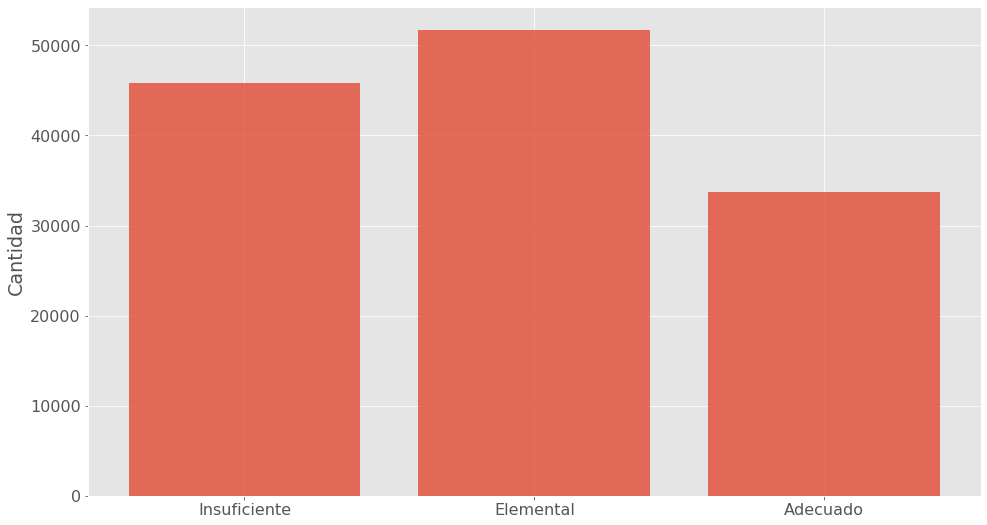

In [37]:
data = getData(5)
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
y_pos = np.arange(len(target_names))
values = []
values.append(data['ptje_mate'].value_counts()[0]) 
values.append(data['ptje_mate'].value_counts()[1])
values.append(data['ptje_mate'].value_counts()[2])
fig, ax = plt.subplots(figsize=(16,9))  
plt.bar(y_pos, values, align='center', alpha=0.8)
plt.xticks(y_pos, target_names)
plt.ylabel('Cantidad')
plt.savefig('count_by_class_all.pdf') 

In [38]:
values

[45857, 51722, 33672]

In [39]:
target = pd.DataFrame(data = data[ptje_target])
data.drop([ptje_target], axis = 1 , inplace = True)
features = data
names_columns = data.columns
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

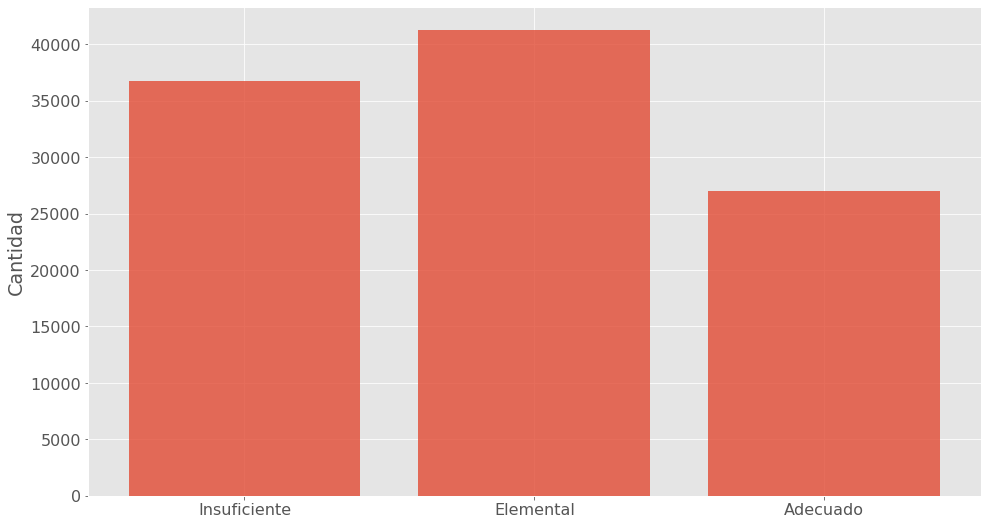

In [40]:
values = []
values.append(train_labels['ptje_mate'].value_counts()[0]) 
values.append(train_labels['ptje_mate'].value_counts()[1])
values.append(train_labels['ptje_mate'].value_counts()[2])
fig, ax = plt.subplots(figsize=(16,9))  
plt.bar(y_pos, values, align='center', alpha=0.8)
plt.xticks(y_pos, target_names)
plt.ylabel('Cantidad')
plt.savefig('count_by_class_train.pdf') 

In [41]:
values

[36728, 41264, 27008]

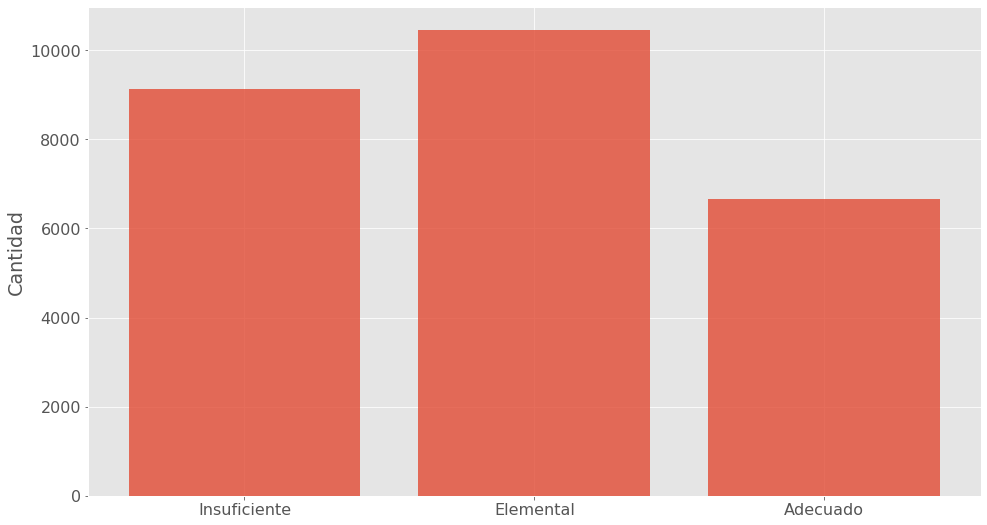

In [42]:
values = []
values.append(test_labels['ptje_mate'].value_counts()[0]) 
values.append(test_labels['ptje_mate'].value_counts()[1])
values.append(test_labels['ptje_mate'].value_counts()[2])
fig, ax = plt.subplots(figsize=(16,9))  
plt.bar(y_pos, values, align='center', alpha=0.8)
plt.xticks(y_pos, target_names)
plt.ylabel('Cantidad')
plt.savefig('count_by_class_test.pdf') 

In [43]:
values

[9129, 10458, 6664]

In [64]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

def classification_report_with_accuracy_score(y_true, y_pred):
    global model_scores
    global global_confusion_matrix
    global global_accuracy
    
    global_confusion_matrix.append(confusion_matrix(y_true, y_pred))
    global_accuracy.append(accuracy_score(y_true, y_pred))
    model_scores.append(classification_report(y_true, y_pred, target_names=target_names, output_dict=True))
    return accuracy_score(y_true, y_pred)


def custom_auc(ground_truth, preds):
    global global_roc_auc
    y_score = preds
    y_test = pd.get_dummies(ground_truth, columns=['ptje_mate']).to_numpy()
    n_classes = 3
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    global_roc_auc.append(roc_auc)   
    return roc_auc["macro"]

In [65]:
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)
crwa = make_scorer(classification_report_with_accuracy_score)

In [66]:
data_global = [[],[],[],[],[],[],[],[],[]]

## Regresión Logistica 3 Clases - lbfgs

In [67]:
data = getData(5)
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data[ptje_target])
data.drop([ptje_target], axis = 1 , inplace = True)
names_columns = data.columns

features = data

model = LogisticRegression( 
  multi_class='multinomial', 
  solver='lbfgs')
model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

start_time = time.time()
model.fit(train_features, train_labels)
t = time.time() - start_time
print("--- %s seconds model exec ---" % (t))
preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
preds_log_proba_test = model.predict_log_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 18.11290740966797 seconds model exec ---
acc train:  0.5144190476190477
[[22111 12273  2329]
 [12424 22045  7003]
 [ 3254 13703  9858]]
              precision    recall  f1-score   support

Insuficiente       0.59      0.60      0.59     36713
   Elemental       0.46      0.53      0.49     41472
    Adecuado       0.51      0.37      0.43     26815

    accuracy                           0.51    105000
   macro avg       0.52      0.50      0.50    105000
weighted avg       0.52      0.51      0.51    105000

acc test:  0.5085520551598034
[[5432 3090  622]
 [3046 5421 1783]
 [ 830 3530 2497]]
              precision    recall  f1-score   support

Insuficiente       0.58      0.59      0.59      9144
   Elemental       0.45      0.53      0.49     10250
    Adecuado       0.51      0.36      0.42      6857

    accuracy                           0.51     26251
   macro avg       0.51      0.50      0.50     26251
weighted avg       0.51      0.51      0.51     26251



In [68]:
data_global[0].append(global_accuracy)
data_global[0].append(model_scores)
data_global[0].append(global_confusion_matrix)
data_global[0].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.2575
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[2749. 1538.  299.]
 [1542. 2724.  906.]
 [ 402. 1677. 1288.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.59 0.6 0.59
Elemental 0.46 0.53 0.49
Adecuado 0.52 0.38 0.44
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.7465849165522003, 1: 0.5861899571048056, 2: 0.7349808310253051, 'micro': 0.7071557690557371, 'macro': 0.6892812793553421}
{0: 0.7656335554775051, 1: 0.5955790916938639, 2: 0.749858865507564, 'micro': 0.7218366265759637, 'macro': 0.7037196756794911}
{0: 0.7483627767386191, 1: 0.5896684664904379, 2: 0.7349489713526287, 'micro': 0.7098380741950112, 'macro': 0.6910229729095163}
{0: 0.7664872398056255, 1: 0.5956046308508738, 2: 0.7564756632678002, 'micro': 0.7242667232653062, 'macro': 0.7062183138437217}
{0: 0.7574763708622638, 1: 0.582070002699997, 2: 0.74

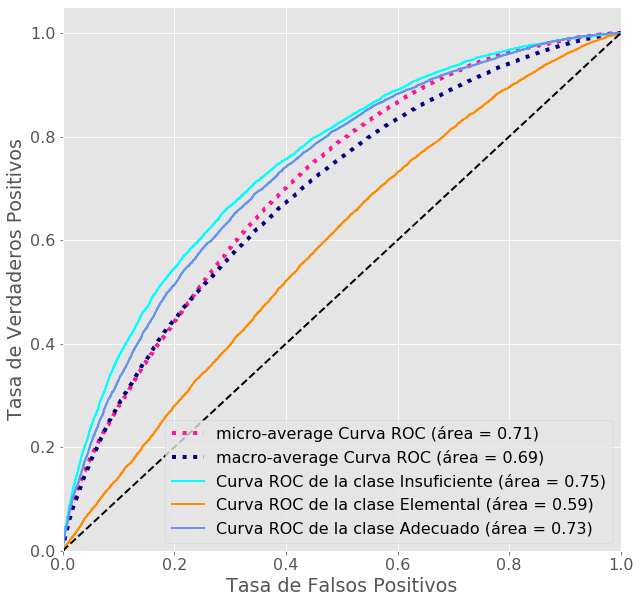

In [69]:
plot_roc_auc_scores(3, preds_proba_test, test_labels, save=1, name="mlr-lbfgs-roc-auc")

In [70]:
df_t_m1 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m1['class'] = test_labels[ptje_target].values
df_t_m1['pred'] = preds
df_t_m1['correct'] = np.where(df_t_m1['pred'] == df_t_m1['class'], 1, 0)

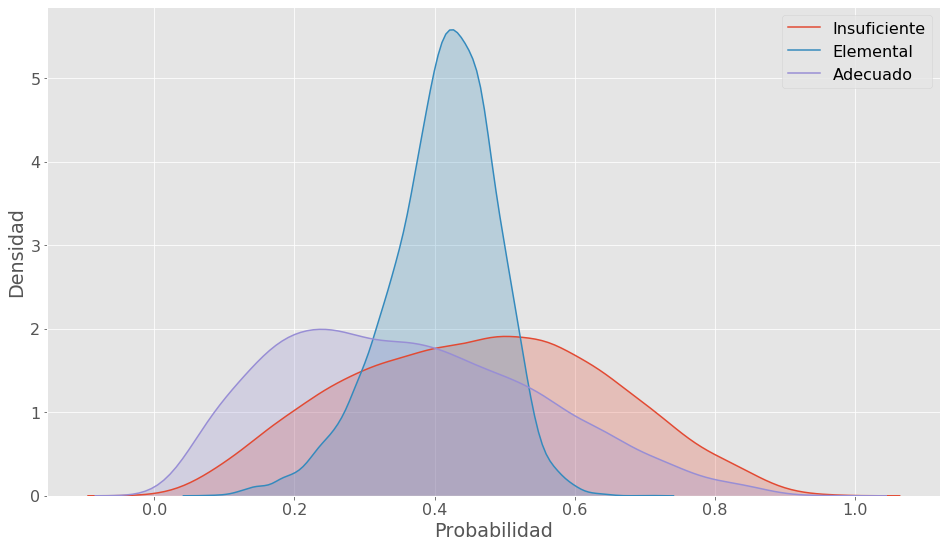

In [71]:
plt.figure(figsize=(16,9))
plt.ylabel("Densidad")
plt.xlabel("Probabilidad")
for clm, df_test in df_t_m1.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)])
plt.savefig('mlr-lbfgs-prob-class-graph.pdf') 

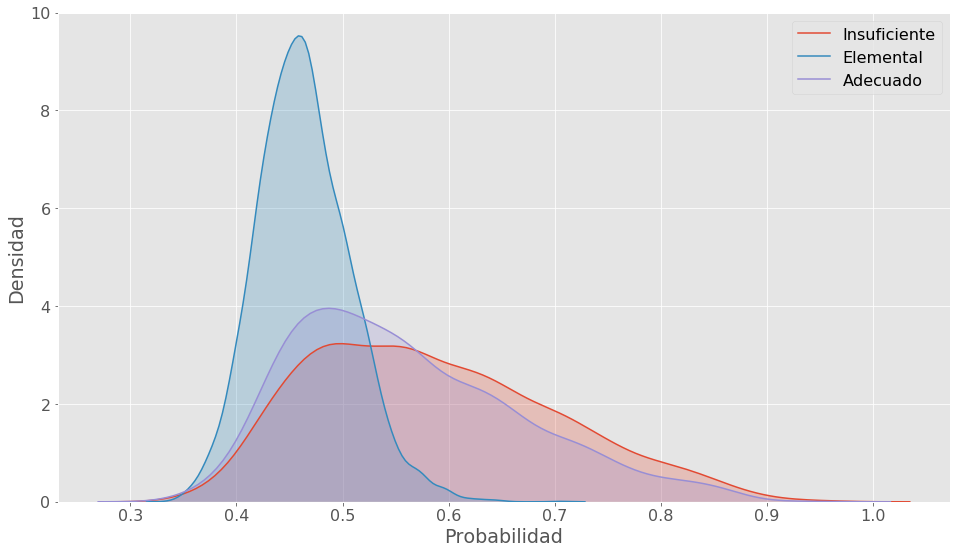

In [72]:
plt.figure(figsize=(16,9))
plt.ylabel("Densidad")
plt.xlabel("Probabilidad")
for clm, df_test in df_t_m1[df_t_m1['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)])
plt.savefig('mlr-lbfgs-prob-corrrect-class-graph.pdf') 

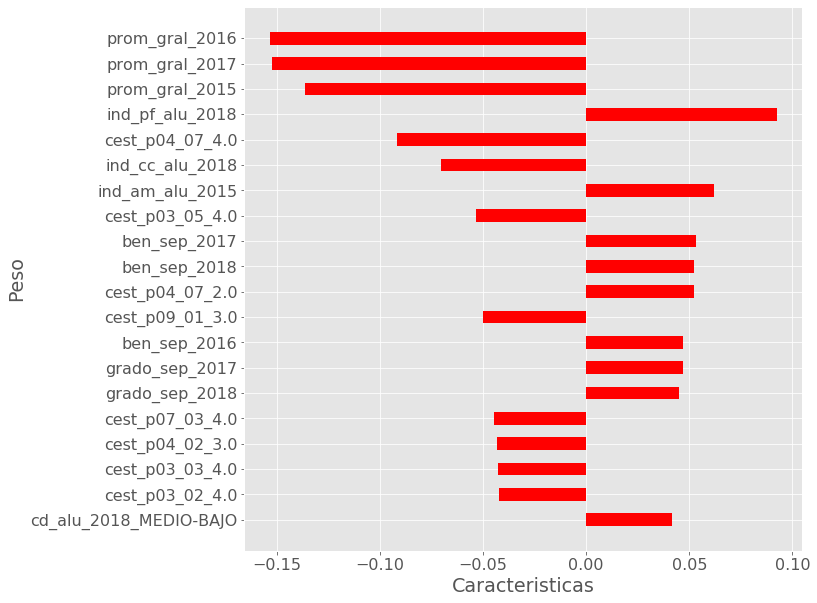

In [73]:
importance = {}
for i in range(len(model.coef_[0])):
    importance[features.columns[i]] = model.coef_[0][i]
importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)
num_features = 20
y = []
x = []
for i in range(num_features):
    y.append(importance[num_features-1-i][1])
    x.append(importance[num_features-1-i][0]) 
fig, ax = plt.subplots(figsize=(10,10))  
width = 0.5 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="red")
ax.set_yticks((ind+width/2)-0.25)
ax.set_yticklabels(x, minor=False)
plt.xlabel('Caracteristicas')
plt.ylabel('Peso')
plt.savefig('mlr-lbfgs-features-importance.pdf', bbox_inches='tight') 

In [74]:
features_vif = []
importance2 = importance[:20]
for i in range(len(importance2)):
    features_vif.append(importance2[i][0])
X = features[features_vif].iloc[:,:]
r = calc_vif(X)

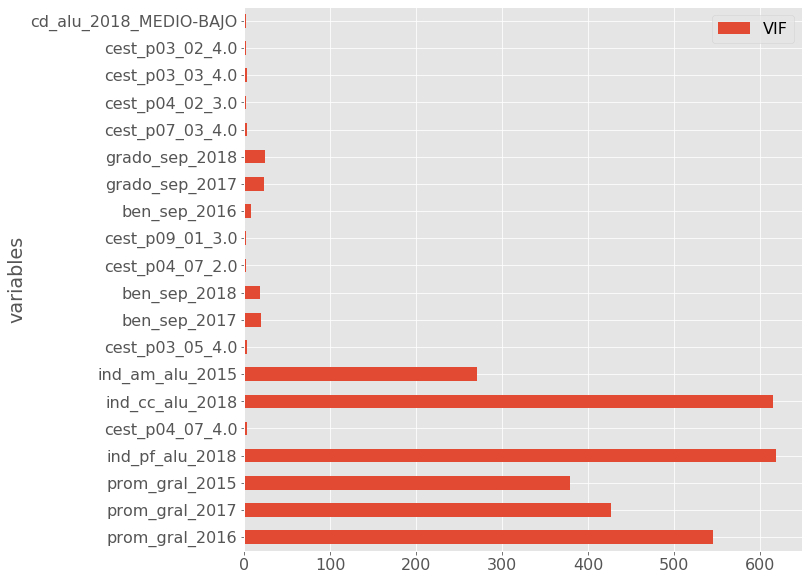

In [75]:
fig = r.plot(x='variables', y='VIF', kind='barh', figsize=(10, 10)).get_figure()
fig.savefig('mlr-lbfgs-vif.pdf', bbox_inches='tight')

In [76]:
data = getData(5)
data2 = data[features_vif+['ptje_mate']]
#data2 = data2.drop(columns=['prom_gral_2015','prom_gral_2016', 'ind_am_alu_2015','ind_am_alu_2015',])

In [77]:
data = data2
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data[ptje_target])
data.drop([ptje_target], axis = 1 , inplace = True)
names_columns = data.columns

features = data

model = LogisticRegression( 
  multi_class='multinomial', 
  solver='lbfgs')
model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

start_time = time.time()
model.fit(train_features, train_labels)
t = time.time() - start_time
print("--- %s seconds model exec ---" % (t))
preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
preds_log_proba_test = model.predict_log_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 2.7395267486572266 seconds model exec ---
acc train:  0.5427238095238095
[[21645 12978  2010]
 [10998 21986  8430]
 [ 2137 11461 13355]]
              precision    recall  f1-score   support

Insuficiente       0.62      0.59      0.61     36633
   Elemental       0.47      0.53      0.50     41414
    Adecuado       0.56      0.50      0.53     26953

    accuracy                           0.54    105000
   macro avg       0.55      0.54      0.54    105000
weighted avg       0.55      0.54      0.54    105000

acc test:  0.5413888994704964
[[5463 3285  476]
 [2742 5420 2146]
 [ 492 2898 3329]]
              precision    recall  f1-score   support

Insuficiente       0.63      0.59      0.61      9224
   Elemental       0.47      0.53      0.49     10308
    Adecuado       0.56      0.50      0.53      6719

    accuracy                           0.54     26251
   macro avg       0.55      0.54      0.54     26251
weighted avg       0.55      0.54      0.54     26251



In [78]:
data_global[1].append(global_accuracy)
data_global[1].append(model_scores)
data_global[1].append(global_confusion_matrix)
data_global[1].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.2714
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[2729. 1619.  237.]
 [1395. 2778.  999.]
 [ 276. 1474. 1617.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.62 0.6 0.61
Elemental 0.47 0.54 0.5
Adecuado 0.57 0.48 0.52
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.7850682382148252, 1: 0.6067673490407386, 2: 0.7914190370591172, 'micro': 0.7454925023464988, 'macro': 0.7277806708642056}
{0: 0.7768223676216974, 1: 0.5986924680953813, 2: 0.7780046048133771, 'micro': 0.7358565667120182, 'macro': 0.7178690034326157}
{0: 0.7807791725993012, 1: 0.6068352040093055, 2: 0.791567665299475, 'micro': 0.743360460770975, 'macro': 0.7264231497712365}
{0: 0.7840990729394046, 1: 0.6065237486532303, 2: 0.7857601346405405, 'micro': 0.7431716266666667, 'macro': 0.7254903214328926}
{0: 0.785196189356766, 1: 0.6111777760905646, 2: 0.7919

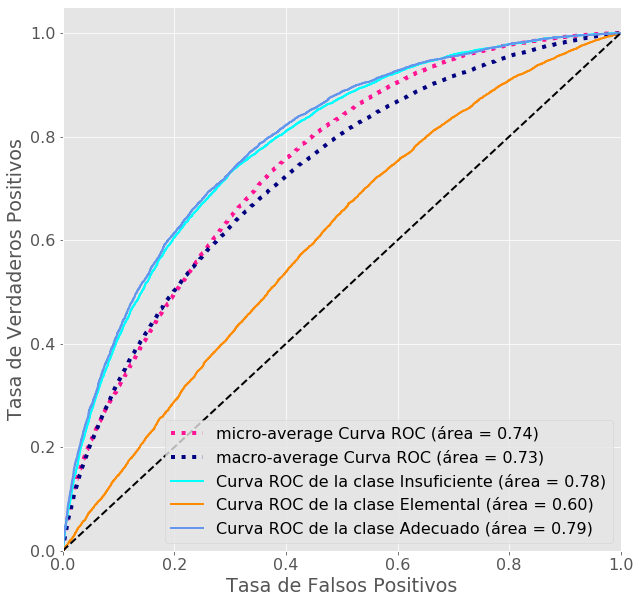

In [79]:
plot_roc_auc_scores(3, preds_proba_test, test_labels, save=1, name="mlr-lbfgs-2-roc-auc")

In [80]:
df_t_m2 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m2['class'] = test_labels[ptje_target].values
df_t_m2['pred'] = preds
df_t_m2['correct'] = np.where(df_t_m2['pred'] == df_t_m2['class'], 1, 0)

In [81]:
data = getData(6)
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data[ptje_target])
data.drop([ptje_target], axis = 1 , inplace = True)
names_columns = data.columns

features = data

model = LogisticRegression( 
  multi_class='multinomial', 
  solver='lbfgs')
model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

start_time = time.time()
model.fit(train_features, train_labels)
t = time.time() - start_time
print("--- %s seconds model exec ---" % (t))
preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
preds_log_proba_test = model.predict_log_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 17.712351322174072 seconds model exec ---
acc train:  0.49123809523809525
[[19451 14729  2422]
 [12034 22914  6460]
 [ 3817 13958  9215]]
              precision    recall  f1-score   support

Insuficiente       0.55      0.53      0.54     36602
   Elemental       0.44      0.55      0.49     41408
    Adecuado       0.51      0.34      0.41     26990

    accuracy                           0.49    105000
   macro avg       0.50      0.48      0.48    105000
weighted avg       0.50      0.49      0.49    105000

acc test:  0.49110510075806635
[[4900 3735  620]
 [2966 5775 1573]
 [ 974 3491 2217]]
              precision    recall  f1-score   support

Insuficiente       0.55      0.53      0.54      9255
   Elemental       0.44      0.56      0.50     10314
    Adecuado       0.50      0.33      0.40      6682

    accuracy                           0.49     26251
   macro avg       0.50      0.47      0.48     26251
weighted avg       0.50      0.49      0.49     26251



In [82]:
data_global[2].append(global_accuracy)
data_global[2].append(model_scores)
data_global[2].append(global_confusion_matrix)
data_global[2].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.2483
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[2506. 1799.  281.]
 [1544. 2852.  776.]
 [ 474. 1733. 1160.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.55 0.55 0.55
Elemental 0.45 0.55 0.49
Adecuado 0.52 0.34 0.42
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.7111031540226842, 1: 0.5719875535080828, 2: 0.7142041483897301, 'micro': 0.6860784830019975, 'macro': 0.665794171625495}
{0: 0.7250519497963848, 1: 0.5804426779411164, 2: 0.7293856782609601, 'micro': 0.6972473621768707, 'macro': 0.6783222835494876}
{0: 0.7232074167146024, 1: 0.577178694308957, 2: 0.7293449445261397, 'micro': 0.6957756059863945, 'macro': 0.6766064665494126}
{0: 0.7267488625165451, 1: 0.5904475627256769, 2: 0.7264900260416816, 'micro': 0.7000600047165533, 'macro': 0.6812577932977191}
{0: 0.7281818964391441, 1: 0.5827569336440919, 2: 0.7

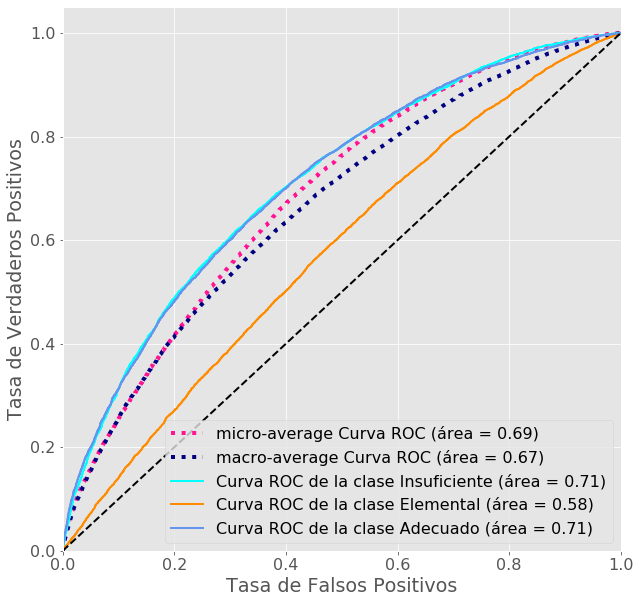

In [83]:
plot_roc_auc_scores(3, preds_proba_test, test_labels, save=1, name="mlr-lbfgs-roc-auc")

In [84]:
df_t_m3 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m3['class'] = test_labels[ptje_target].values
df_t_m3['pred'] = preds
df_t_m3['correct'] = np.where(df_t_m3['pred'] == df_t_m3['class'], 1, 0)

## Regresión Logistica 3 Clases - newton-cg

In [85]:
data = getData(5)
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data[ptje_target])
data.drop([ptje_target], axis = 1 , inplace = True)
names_columns = data.columns

features = data

model = LogisticRegression( 
  multi_class='multinomial', 
  solver='newton-cg')

model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

start_time = time.time()
model.fit(train_features, train_labels)
print("--- %s seconds model exec ---" % (time.time() - start_time))
preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
preds_log_proba_test = model.predict_log_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 1157.659718990326 seconds model exec ---
acc train:  0.6236380952380952
[[24503 11392   772]
 [ 9546 24699  7200]
 [ 1058  9550 16280]]
              precision    recall  f1-score   support

Insuficiente       0.70      0.67      0.68     36667
   Elemental       0.54      0.60      0.57     41445
    Adecuado       0.67      0.61      0.64     26888

    accuracy                           0.62    105000
   macro avg       0.64      0.62      0.63    105000
weighted avg       0.63      0.62      0.63    105000

acc test:  0.6125861871928688
[[6080 2927  183]
 [2421 5979 1877]
 [ 264 2498 4022]]
              precision    recall  f1-score   support

Insuficiente       0.69      0.66      0.68      9190
   Elemental       0.52      0.58      0.55     10277
    Adecuado       0.66      0.59      0.63      6784

    accuracy                           0.61     26251
   macro avg       0.63      0.61      0.62     26251
weighted avg       0.62      0.61      0.61     26251



In [86]:
data_global[3].append(global_accuracy)
data_global[3].append(model_scores)
data_global[3].append(global_confusion_matrix)
data_global[3].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.3089
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[3047. 1440.   98.]
 [1207. 3037.  928.]
 [ 135. 1209. 2023.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.69 0.66 0.68
Elemental 0.53 0.59 0.56
Adecuado 0.66 0.6 0.63
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.8503561016206007, 1: 0.6819363178684438, 2: 0.8633316915228256, 'micro': 0.8126980245493161, 'macro': 0.7985707716804347}
{0: 0.8551282679655471, 1: 0.6807059739824833, 2: 0.865285795368804, 'micro': 0.8147246236734693, 'macro': 0.8004024112247692}
{0: 0.8503363738281557, 1: 0.6809809387207073, 2: 0.8642028765260985, 'micro': 0.812610073106576, 'macro': 0.7985360734923553}
{0: 0.8514485970759749, 1: 0.6792065021599732, 2: 0.8652625189825437, 'micro': 0.8128808961451247, 'macro': 0.7986683179912639}
{0: 0.8533564980210975, 1: 0.6822030013627043, 2: 0.86

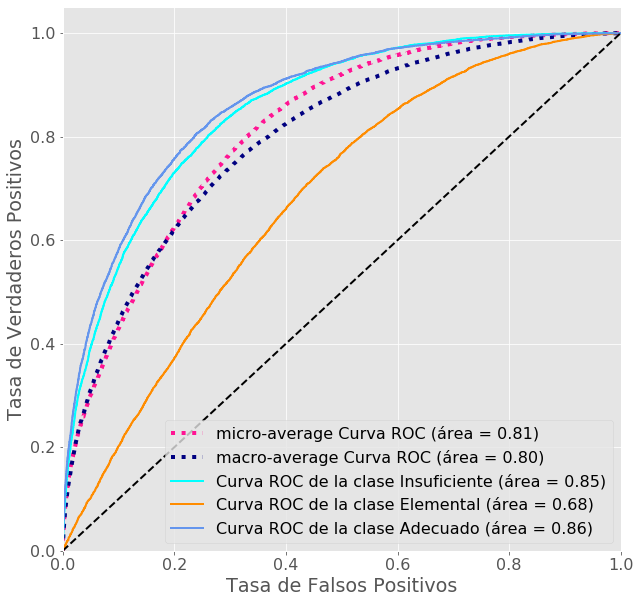

In [87]:
plot_roc_auc_scores(3, preds_proba_test, test_labels, save=1, name="mlr-newton-cg-roc-auc")

In [88]:
df_t_m4 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m4['class'] = test_labels[ptje_target].values
df_t_m4['pred'] = preds
df_t_m4['correct'] = np.where(df_t_m4['pred'] == df_t_m4['class'], 1, 0)

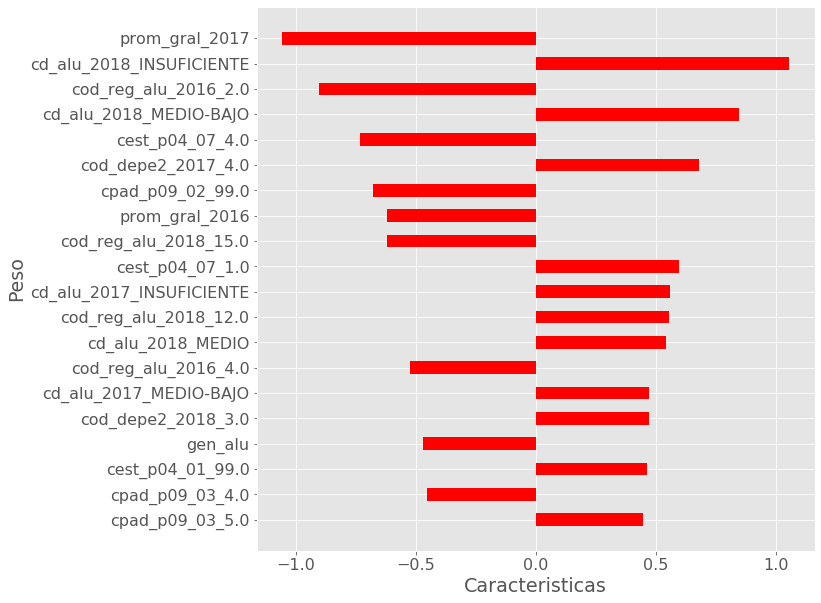

In [89]:
importance = {}
for i in range(len(model.coef_[0])):
    importance[features.columns[i]] = model.coef_[0][i]
importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)
num_features = 20
y = []
x = []
for i in range(num_features):
    y.append(importance[num_features-1-i][1])
    x.append(importance[num_features-1-i][0]) 
fig, ax = plt.subplots(figsize=(10,10))  
width = 0.5 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="red")
ax.set_yticks((ind+width/2)-0.25)
ax.set_yticklabels(x, minor=False)
plt.xlabel('Caracteristicas')
plt.ylabel('Peso')
plt.savefig('mlr-newton-cg-features-importance.pdf', bbox_inches='tight') 

In [90]:
features_vif = []
importance2 = importance[:20]
for i in range(len(importance2)):
    features_vif.append(importance2[i][0])
X = features[features_vif].iloc[:,:]
r = calc_vif(X)

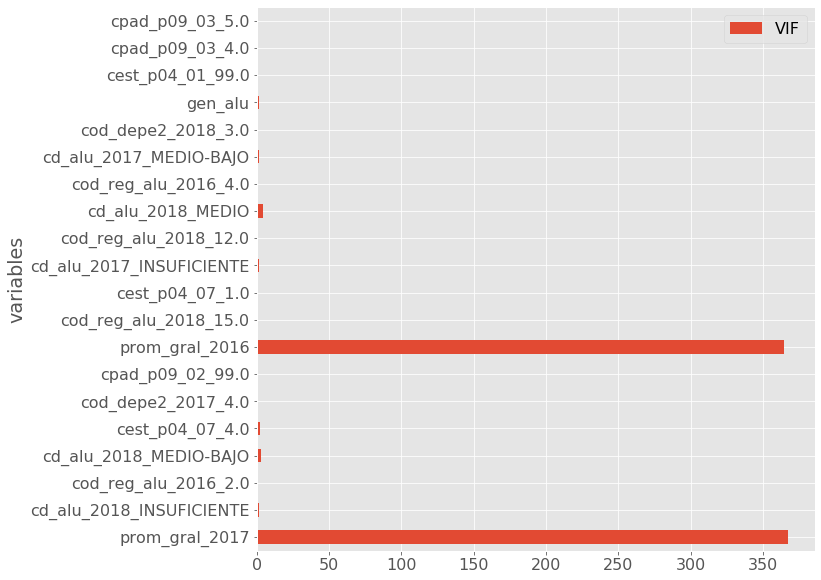

In [91]:
fig = r.plot(x='variables', y='VIF', kind='barh', figsize=(10, 10)).get_figure()
fig.savefig('mlr-newton-cg-vif.pdf', bbox_inches='tight')

In [92]:
data = getData(5)
data2 = data[features_vif+['ptje_mate']]
#data2 = data2.drop(columns=['prom_gral_2016'])

In [93]:
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data2.loc[data2['ptje_mate'] < 245, 'ptje_mate'] = 0
data2.loc[data2['ptje_mate'] >= 295, 'ptje_mate'] = 2
data2.loc[data2['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data2[ptje_target])
data2.drop([ptje_target], axis = 1 , inplace = True)
names_columns = data2.columns
#scaler = StandardScaler()
#features = pd.DataFrame(data = scaler.fit_transform(data), columns=names_columns)
features = data2
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123
model = LogisticRegression( 
  multi_class='multinomial', 
  solver='newton-cg', 
  fit_intercept=True,
  n_jobs=-1)

model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123


start_time = time.time()
model.fit(train_features, train_labels)
print("--- %s seconds model exec ---" % (time.time() - start_time))

preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
preds_log_proba_test = model.predict_log_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 14.928378105163574 seconds model exec ---
acc train:  0.5899142857142857
[[23170 12416  1126]
 [10322 23455  7581]
 [ 1430 10184 15316]]
              precision    recall  f1-score   support

Insuficiente       0.66      0.63      0.65     36712
   Elemental       0.51      0.57      0.54     41358
    Adecuado       0.64      0.57      0.60     26930

    accuracy                           0.59    105000
   macro avg       0.60      0.59      0.59    105000
weighted avg       0.60      0.59      0.59    105000

acc test:  0.5840539408022551
[[5701 3183  261]
 [2578 5866 1920]
 [ 353 2624 3765]]
              precision    recall  f1-score   support

Insuficiente       0.66      0.62      0.64      9145
   Elemental       0.50      0.57      0.53     10364
    Adecuado       0.63      0.56      0.59      6742

    accuracy                           0.58     26251
   macro avg       0.60      0.58      0.59     26251
weighted avg       0.59      0.58      0.59     26251



In [94]:
data_global[4].append(global_accuracy)
data_global[4].append(model_scores)
data_global[4].append(global_confusion_matrix)
data_global[4].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.2943
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[2886. 1562.  138.]
 [1291. 2932.  950.]
 [ 179. 1281. 1907.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.66 0.63 0.65
Elemental 0.51 0.57 0.54
Adecuado 0.64 0.57 0.6
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.8215368670513944, 1: 0.6472985380458672, 2: 0.8371717919608497, 'micro': 0.7845435808471104, 'macro': 0.768677321244573}
{0: 0.8197608822117649, 1: 0.6491391081866125, 2: 0.8392135224862218, 'micro': 0.7852952736507937, 'macro': 0.7693791234143852}
{0: 0.8212940604936881, 1: 0.6483752118376436, 2: 0.8430127857136465, 'micro': 0.7868204691156462, 'macro': 0.77090216398804}
{0: 0.8259497724378646, 1: 0.6452193512125423, 2: 0.8402198552459876, 'micro': 0.7868411312471656, 'macro': 0.7704709853709193}
{0: 0.8233517816648245, 1: 0.6471747620567431, 2: 0.840

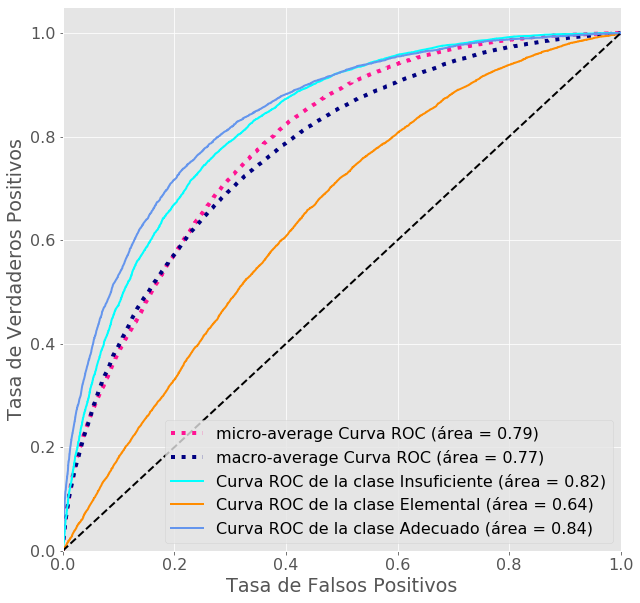

In [95]:
plot_roc_auc_scores(3, preds_proba_test, test_labels, save=1, name="mlr-newton-cg-2-roc-auc")

In [96]:
df_t_m5 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m5['class'] = test_labels[ptje_target].values
df_t_m5['pred'] = preds
df_t_m5['correct'] = np.where(df_t_m5['pred'] == df_t_m5['class'], 1, 0)

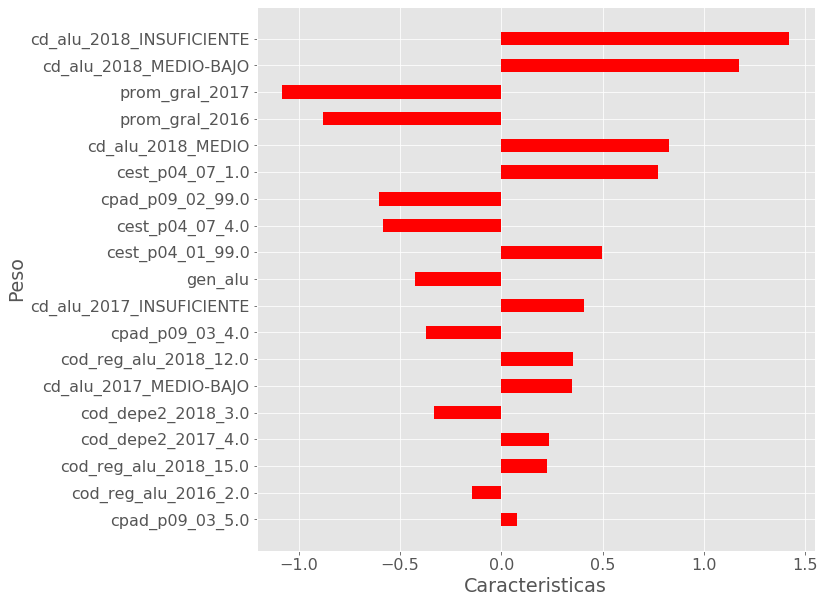

In [97]:
importance = {}
for i in range(len(model.coef_[0])):
    importance[features.columns[i]] = model.coef_[0][i]
importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)
num_features = 19
y = []
x = []
for i in range(num_features):
    y.append(importance[num_features-1-i][1])
    x.append(importance[num_features-1-i][0]) 
fig, ax = plt.subplots(figsize=(10,10))  
width = 0.5 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="red")
ax.set_yticks((ind+width/2)-0.25)
ax.set_yticklabels(x, minor=False)
plt.xlabel('Caracteristicas')
plt.ylabel('Peso')
plt.savefig('mlr-newton-cg-2-features-importance.pdf', bbox_inches='tight') 

In [98]:
features_vif = []
importance2 = importance[:20]
for i in range(len(importance2)):
    features_vif.append(importance2[i][0])
X = features[features_vif].iloc[:,:]
r = calc_vif(X)

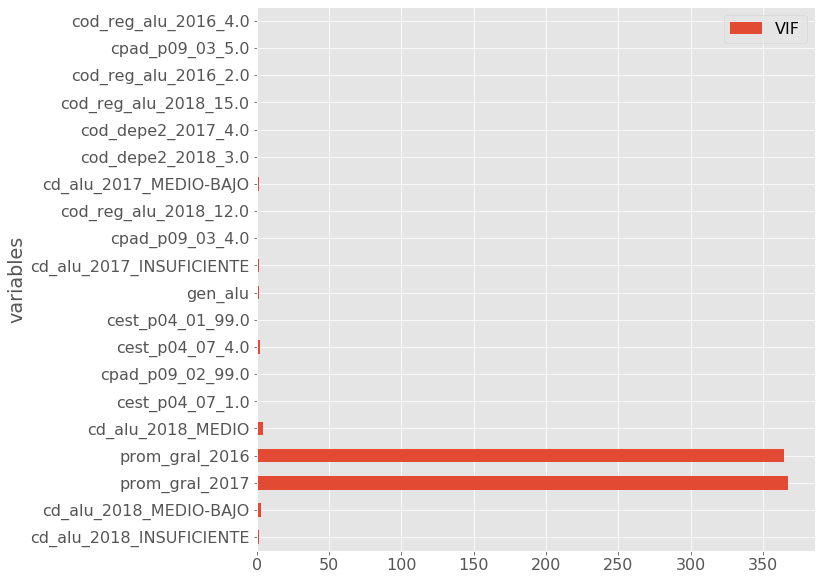

In [99]:
fig = r.plot(x='variables', y='VIF', kind='barh', figsize=(10, 10)).get_figure()
fig.savefig('mlr-newton-cg-2-vif.pdf', bbox_inches='tight') 

In [100]:
data = getData(6)
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data[ptje_target])
data.drop([ptje_target], axis = 1 , inplace = True)
names_columns = data.columns

features = data

model = LogisticRegression( 
  multi_class='multinomial', 
  solver='newton-cg')

model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

start_time = time.time()
model.fit(train_features, train_labels)
print("--- %s seconds model exec ---" % (time.time() - start_time))
preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
preds_log_proba_test = model.predict_log_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 1313.9289569854736 seconds model exec ---
acc train:  0.5732190476190476
[[22657 12504  1555]
 [10587 23300  7442]
 [ 1823 10901 14231]]
              precision    recall  f1-score   support

Insuficiente       0.65      0.62      0.63     36716
   Elemental       0.50      0.56      0.53     41329
    Adecuado       0.61      0.53      0.57     26955

    accuracy                           0.57    105000
   macro avg       0.59      0.57      0.58    105000
weighted avg       0.58      0.57      0.57    105000

acc test:  0.5685116757456858
[[5588 3151  402]
 [2728 5848 1817]
 [ 479 2750 3488]]
              precision    recall  f1-score   support

Insuficiente       0.64      0.61      0.62      9141
   Elemental       0.50      0.56      0.53     10393
    Adecuado       0.61      0.52      0.56      6717

    accuracy                           0.57     26251
   macro avg       0.58      0.56      0.57     26251
weighted avg       0.57      0.57      0.57     26251



In [101]:
df_t_m6 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m6['class'] = test_labels[ptje_target].values
df_t_m6['pred'] = preds
df_t_m6['correct'] = np.where(df_t_m6['pred'] == df_t_m6['class'], 1, 0)

In [102]:
data_global[5].append(global_accuracy)
data_global[5].append(model_scores)
data_global[5].append(global_confusion_matrix)
data_global[5].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.2836
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[2793. 1593.  200.]
 [1338. 2894.  940.]
 [ 229. 1382. 1757.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.64 0.61 0.62
Elemental 0.49 0.56 0.52
Adecuado 0.61 0.52 0.56
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.8030112853618573, 1: 0.6367420166648264, 2: 0.8172719378370067, 'micro': 0.7680513937905118, 'macro': 0.7523709658917471}
{0: 0.8056931188730359, 1: 0.6425011388689292, 2: 0.8204311228813196, 'micro': 0.7709577650793651, 'macro': 0.756237321493329}
{0: 0.8033248725197432, 1: 0.6393707989179955, 2: 0.820178441540401, 'micro': 0.7693638755555556, 'macro': 0.7543207903652822}
{0: 0.8030454204460228, 1: 0.6320671507617805, 2: 0.8149315681853088, 'micro': 0.7658987580952381, 'macro': 0.7500439847678957}
{0: 0.8056495818396054, 1: 0.6360653715870763, 2: 0.8

## LiGHTGBM  MODEL 3 CLASS

In [103]:
data = getData(5)
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data['ptje_mate'])
data.drop(['ptje_mate'], axis = 1 , inplace = True)
names_columns = data.columns
features = data

model = LGBMClassifier(booster_type="gbdt", 
                       metric=["multi_logloss"], 
                       importance_type="gain")
model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

eval_set = [(train_features, train_labels), (test_features, test_labels)]
start_time = time.time()
model.fit(train_features, train_labels, eval_set = eval_set, verbose=0)
print("--- %s seconds model exec ---" % (time.time() - start_time))
preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 4.340720891952515 seconds model exec ---
acc train:  0.6497714285714286
[[25927 10114   551]
 [ 9472 26278  5774]
 [ 1121  9742 16021]]
              precision    recall  f1-score   support

Insuficiente       0.71      0.71      0.71     36592
   Elemental       0.57      0.63      0.60     41524
    Adecuado       0.72      0.60      0.65     26884

    accuracy                           0.65    105000
   macro avg       0.67      0.65      0.65    105000
weighted avg       0.66      0.65      0.65    105000

acc test:  0.6247381052150395
[[6382 2733  150]
 [2552 6100 1546]
 [ 280 2590 3918]]
              precision    recall  f1-score   support

Insuficiente       0.69      0.69      0.69      9265
   Elemental       0.53      0.60      0.56     10198
    Adecuado       0.70      0.58      0.63      6788

    accuracy                           0.62     26251
   macro avg       0.64      0.62      0.63     26251
weighted avg       0.63      0.62      0.63     26251



In [104]:
data_global[6].append(global_accuracy)
data_global[6].append(model_scores)
data_global[6].append(global_confusion_matrix)
data_global[6].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.3119
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[3156. 1356.   74.]
 [1287. 3090.  796.]
 [ 145. 1279. 1943.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.69 0.69 0.69
Elemental 0.54 0.6 0.57
Adecuado 0.69 0.58 0.63
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.858279846097304, 1: 0.693252382090779, 2: 0.8734078127964751, 'micro': 0.8220497394164258, 'macro': 0.8083424797982361}
{0: 0.8552058506142542, 1: 0.6838708079923146, 2: 0.8678505655088972, 'micro': 0.8163382218594104, 'macro': 0.8023380085541767}
{0: 0.8559765391776952, 1: 0.6886394674518184, 2: 0.8689065099190125, 'micro': 0.8181614403628117, 'macro': 0.8045362455556608}
{0: 0.8549140709612904, 1: 0.6915414551327215, 2: 0.8680686589325655, 'micro': 0.8187055905668935, 'macro': 0.8048705530165492}
{0: 0.8569058924152992, 1: 0.6924214295918141, 2: 0.86

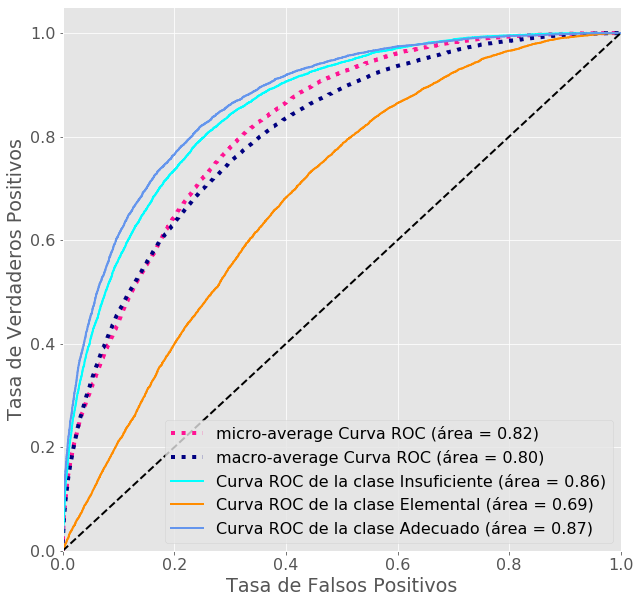

In [105]:
plot_roc_auc_scores(3, preds_proba_test, test_labels, save=1, name="lgbm-roc-auc")

In [106]:
df_t_m7 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m7['class'] = test_labels[ptje_target].values
df_t_m7['pred'] = preds
df_t_m7['correct'] = np.where(df_t_m7['pred'] == df_t_m7['class'], 1, 0)

In [107]:
importance = {}
for i in range(len(model.feature_importances_)):
    importance[features.columns[i]] = model.feature_importances_[i]
importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)

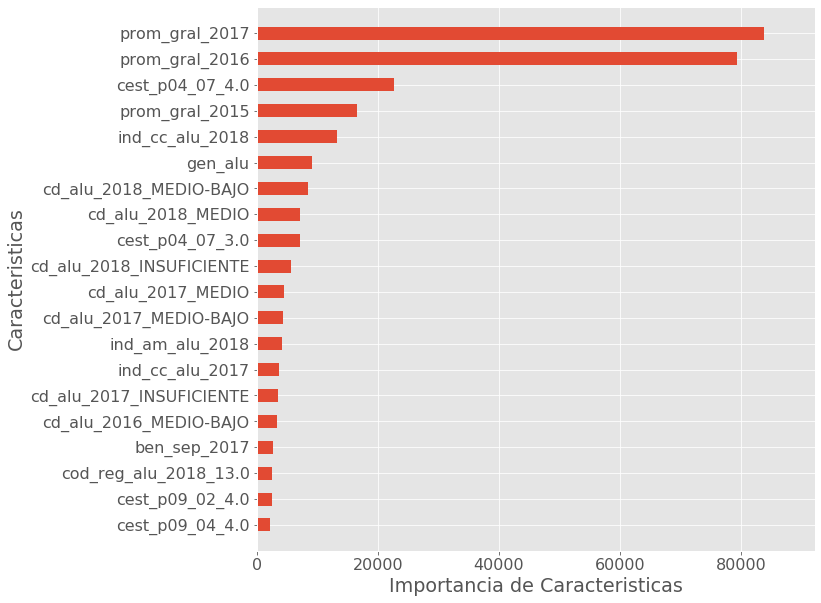

In [108]:
fig = plot_importance(model, figsize=(10,10), height=0.5, max_num_features=20, importance_type="gain", title="", xlabel="Importancia de Caracteristicas", ylabel="Caracteristicas")
for txt in fig.texts:
    txt.set_visible(False)
fig.figure.savefig("lgbm-features-importance.pdf", bbox_inches='tight')

In [109]:
features_vif = []
importance2 = importance[:20]
for i in range(len(importance2)):
    features_vif.append(importance2[i][0])

In [110]:
X = features[features_vif].iloc[:,:]
r = calc_vif(X)

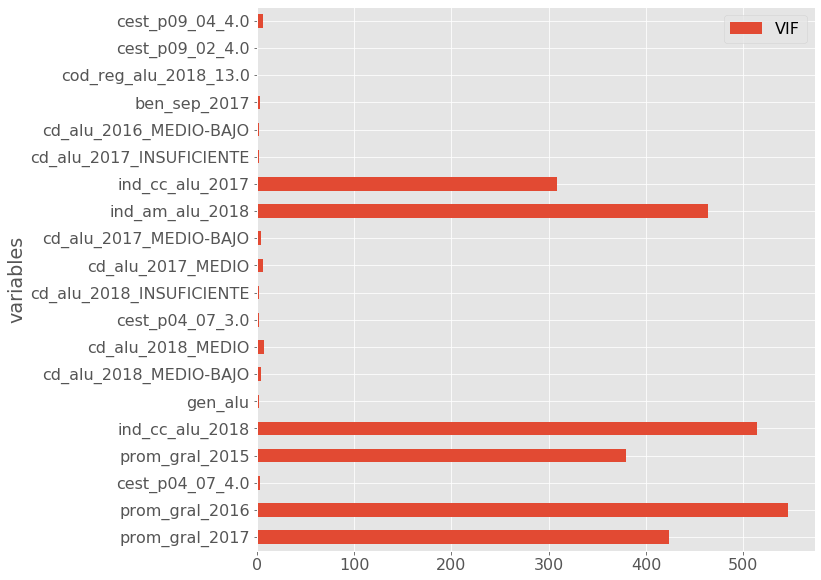

In [111]:
fig = r.plot(x='variables', y='VIF', kind='barh', figsize=(10, 10)).get_figure()
fig.savefig('lgbm-vif.pdf', bbox_inches='tight') 

In [112]:
data = getData(5)
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1

importance = {}
for i in range(len(model.feature_importances_)):
    importance[features.columns[i]] = model.feature_importances_[i]
importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)
used_features = []
importance2 = importance
for i in range(len(importance2)):
    if(importance2[i][1] > 0):
        used_features.append(importance2[i][1])

In [113]:
for i in range(20):
    print(best_features[i], " == " ,str(round((used_features[i]/sum(used_features))*100,2))+"\%")

NameError: name 'best_features' is not defined

In [114]:
data = getData(5)
data = data[features_vif+['ptje_mate']]

In [115]:
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data['ptje_mate'])
data.drop(['ptje_mate'], axis = 1 , inplace = True)
names_columns = data.columns
features = data

model = LGBMClassifier(booster_type="gbdt", 
                       metric=["multi_logloss"], 
                       importance_type="gain")
model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

eval_set = [(train_features, train_labels), (test_features, test_labels)]
start_time = time.time()
model.fit(train_features, train_labels, eval_set = eval_set, verbose=0)
print("--- %s seconds model exec ---" % (time.time() - start_time))
preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 2.4041059017181396 seconds model exec ---
acc train:  0.6268952380952381
[[25316 10696   672]
 [10329 24921  6149]
 [ 1296 10034 15587]]
              precision    recall  f1-score   support

Insuficiente       0.69      0.69      0.69     36684
   Elemental       0.55      0.60      0.57     41399
    Adecuado       0.70      0.58      0.63     26917

    accuracy                           0.63    105000
   macro avg       0.64      0.62      0.63    105000
weighted avg       0.63      0.63      0.63    105000

acc test:  0.6136909070130662
[[6232 2774  167]
 [2653 6046 1624]
 [ 321 2602 3832]]
              precision    recall  f1-score   support

Insuficiente       0.68      0.68      0.68      9173
   Elemental       0.53      0.59      0.56     10323
    Adecuado       0.68      0.57      0.62      6755

    accuracy                           0.61     26251
   macro avg       0.63      0.61      0.62     26251
weighted avg       0.62      0.61      0.61     26251



In [116]:
data_global[7].append(global_accuracy)
data_global[7].append(model_scores)
data_global[7].append(global_confusion_matrix)
data_global[7].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.3065
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[3109. 1392.   85.]
 [1342. 3022.  809.]
 [ 165. 1288. 1914.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.67 0.68 0.68
Elemental 0.53 0.58 0.56
Adecuado 0.68 0.57 0.62
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.8428246860418557, 1: 0.6732958248570784, 2: 0.8626643389171629, 'micro': 0.8075644779063518, 'macro': 0.7929568335430562}
{0: 0.8480322627805367, 1: 0.6805445029717805, 2: 0.8596726862495699, 'micro': 0.8103521139229025, 'macro': 0.79611163000624}
{0: 0.8457121772350416, 1: 0.6734131805127987, 2: 0.8622774765298848, 'micro': 0.8085627972789116, 'macro': 0.7938293477239795}
{0: 0.8451221778116177, 1: 0.6786824622817116, 2: 0.8603977770815237, 'micro': 0.809264415782313, 'macro': 0.7947627064766059}
{0: 0.8436268110192647, 1: 0.676804165184885, 2: 0.858

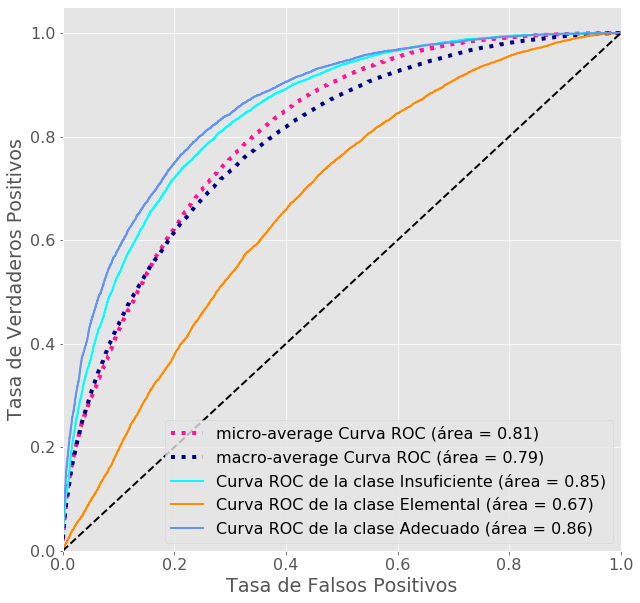

In [117]:
plot_roc_auc_scores(3, preds_proba_test, test_labels, save=1, name="lgbm-2-roc-auc")

In [118]:
df_t_m8 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m8['class'] = test_labels[ptje_target].values
df_t_m8['pred'] = preds
df_t_m8['correct'] = np.where(df_t_m8['pred'] == df_t_m8['class'], 1, 0)

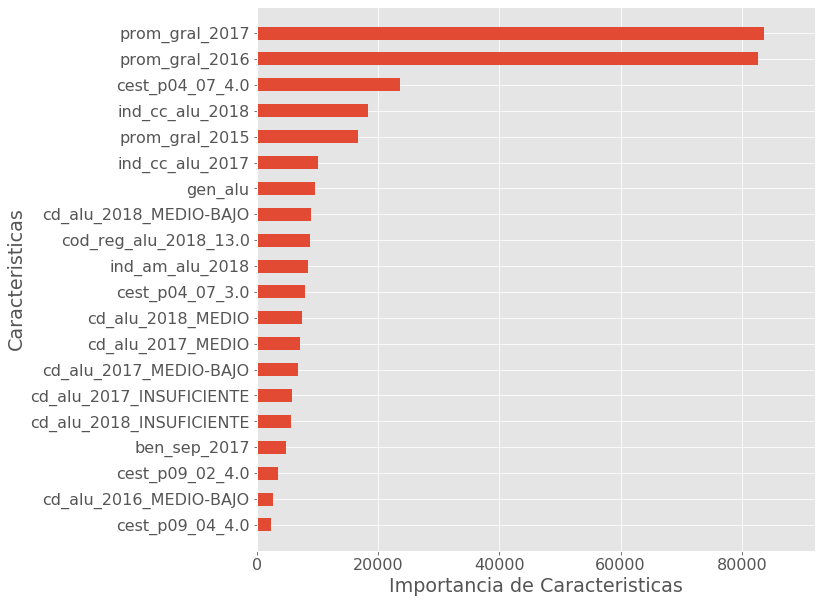

In [119]:
fig = plot_importance(model, figsize=(10,10), height=0.5, max_num_features=20, importance_type="gain", title="", xlabel="Importancia de Caracteristicas", ylabel="Caracteristicas")
for txt in fig.texts:
    txt.set_visible(False)
fig.figure.savefig("lgbm2-features-importance.pdf", bbox_inches='tight')

In [120]:
data = getData(6)
target_names = ['Insuficiente', 'Elemental', 'Adecuado']
#### Menor a 245 = Insuficiente = 0
#### Mayor o igual a 245 y Menor a 295 = Elemental = 1
#### Mayor a 295 = Adecuado = 2
data.loc[data['ptje_mate'] < 245, 'ptje_mate'] = 0
data.loc[data['ptje_mate'] >= 295, 'ptje_mate'] = 2
data.loc[data['ptje_mate'] > 10, 'ptje_mate'] = 1
target = pd.DataFrame(data = data['ptje_mate'])
data.drop(['ptje_mate'], axis = 1 , inplace = True)
names_columns = data.columns
features = data

model = LGBMClassifier(booster_type="gbdt", 
                       metric=["multi_logloss"], 
                       importance_type="gain")
model_scores = []
global_confusion_matrix = []
global_accuracy = []
global_roc_auc = []

scoring = {
    "auc": my_auc,
    "other": crwa
}

score = cross_validate(model, X=features, y=target, cv=5, scoring=scoring)
train_features , test_features , train_labels, test_labels = train_test_split(features , target , test_size=0.20, random_state=123) #123

eval_set = [(train_features, train_labels), (test_features, test_labels)]
start_time = time.time()
model.fit(train_features, train_labels, eval_set = eval_set, verbose=0)
print("--- %s seconds model exec ---" % (time.time() - start_time))
preds = model.predict(train_features)
preds_proba_train = model.predict_proba(train_features)
print("acc train: ", accuracy_score(train_labels, preds))
print(confusion_matrix(train_labels, preds))
print(classification_report(train_labels , preds, target_names=target_names))
preds = model.predict(test_features)
preds_proba_test = model.predict_proba(test_features)
print("acc test: ", accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels , preds, target_names=target_names))

--- 3.7103958129882812 seconds model exec ---
acc train:  0.6006761904761905
[[23733 11626  1368]
 [ 9973 25198  6296]
 [ 1909 10757 14140]]
              precision    recall  f1-score   support

Insuficiente       0.67      0.65      0.66     36727
   Elemental       0.53      0.61      0.57     41467
    Adecuado       0.65      0.53      0.58     26806

    accuracy                           0.60    105000
   macro avg       0.61      0.59      0.60    105000
weighted avg       0.61      0.60      0.60    105000

acc test:  0.5691592701230429
[[5671 3123  336]
 [2683 5831 1741]
 [ 468 2959 3439]]
              precision    recall  f1-score   support

Insuficiente       0.64      0.62      0.63      9130
   Elemental       0.49      0.57      0.53     10255
    Adecuado       0.62      0.50      0.56      6866

    accuracy                           0.57     26251
   macro avg       0.59      0.56      0.57     26251
weighted avg       0.58      0.57      0.57     26251



In [121]:
data_global[8].append(global_accuracy)
data_global[8].append(model_scores)
data_global[8].append(global_confusion_matrix)
data_global[8].append(global_roc_auc)

print("======CROSS VALIDATE x10 ACCURACY ======")
cv_acc = (sum(global_accuracy)/10).round(4) 
print("Cross Validate with 5 times Accuracy: ", cv_acc)
print("======CROSS VALIDATE x10 CONFUSION MATRIX ======")
cv_matrix = (sum(global_confusion_matrix)/10).round(0)
print("Cross Validate with 5 times Matrix Confusion : ")
print(cv_matrix)
print("====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======")
for tg in target_names:
    precision = []
    recall = []
    f1 = []
    for i in range(len(model_scores)):
        precision.append(model_scores[i][tg]['precision'])
        recall.append(model_scores[i][tg]['recall'])
        f1.append(model_scores[i][tg]['f1-score'])
    print(tg, 
          round(sum(precision)/len(precision),2), 
          round(sum(recall)/len(recall),2), 
          round(sum(f1)/len(f1),2))
print(" =======  ======= ")   
print(" ======= AUC SCORES ======= ")
for i in range(len(global_roc_auc)):
    print(global_roc_auc[i])
print(" =======  ======= ")
print(" ======= ACCURACY SCORES ======= ")
for i in range(len(global_accuracy)):
    print(global_accuracy[i])
print(" =======  ======= ")
print(" ======= CONFUSION MATRIX ======= ")    
for i in range(len(global_confusion_matrix)):
    print(global_confusion_matrix[i])

======CROSS VALIDATE x10 ACCURACY ======
Cross Validate with 5 times Accuracy:  0.2846
======CROSS VALIDATE x10 CONFUSION MATRIX ======
Cross Validate with 5 times Matrix Confusion : 
[[2840. 1568.  177.]
 [1365. 2944.  863.]
 [ 241. 1439. 1687.]]
====== CROSS VALIDATE x10 PRESCISION - RECALL - F1 SCORE ======
Insuficiente 0.64 0.62 0.63
Elemental 0.49 0.57 0.53
Adecuado 0.62 0.5 0.55
 =======  ======= 
 ======= AUC SCORES ======= 
{0: 0.8028256469186942, 1: 0.6356669477377472, 2: 0.8197617153222309, 'micro': 0.7686591116596517, 'macro': 0.7527807733457612}
{0: 0.8112253965452125, 1: 0.6392416720467861, 2: 0.8260322242745906, 'micro': 0.7741992402721087, 'macro': 0.7588620443463266}
{0: 0.8057746669605284, 1: 0.6350834955433338, 2: 0.819971213981257, 'micro': 0.7692924081632653, 'macro': 0.7536391297699601}
{0: 0.8041816796900041, 1: 0.6386698025325273, 2: 0.8189198502787353, 'micro': 0.7692029467573696, 'macro': 0.7539526033289914}
{0: 0.8099643770377692, 1: 0.6374495732322989, 2: 0.8

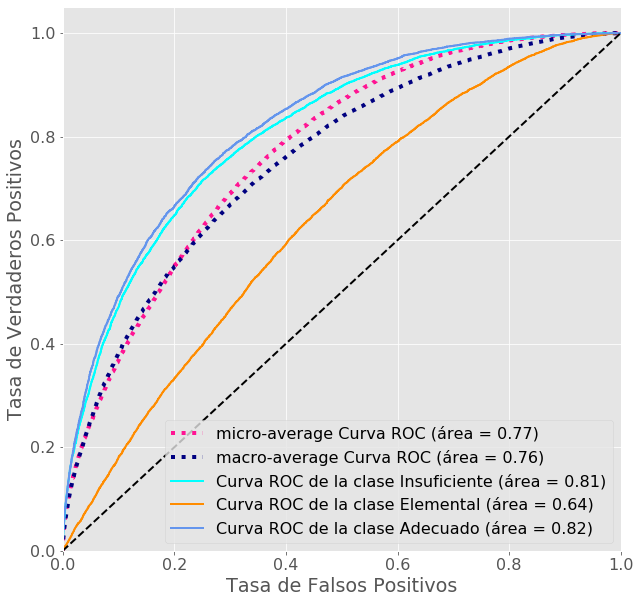

In [122]:
plot_roc_auc_scores(3, preds_proba_test, test_labels, save=1, name="lgbm-3-roc-auc")

In [123]:
df_t_m9 = pd.DataFrame(preds_proba_test, columns=target_names)
df_t_m9['class'] = test_labels[ptje_target].values
df_t_m9['pred'] = preds
df_t_m9['correct'] = np.where(df_t_m9['pred'] == df_t_m9['class'], 1, 0)

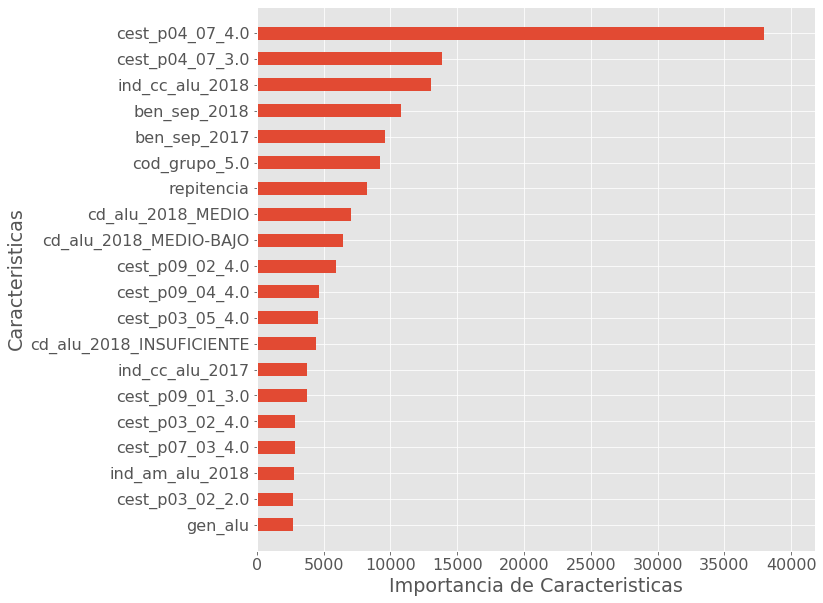

In [124]:
fig = plot_importance(model, figsize=(10,10), height=0.5, max_num_features=20, importance_type="gain", title="", xlabel="Importancia de Caracteristicas", ylabel="Caracteristicas")
for txt in fig.texts:
    txt.set_visible(False)
fig.figure.savefig("lgbm3-features-importance.pdf", bbox_inches='tight')

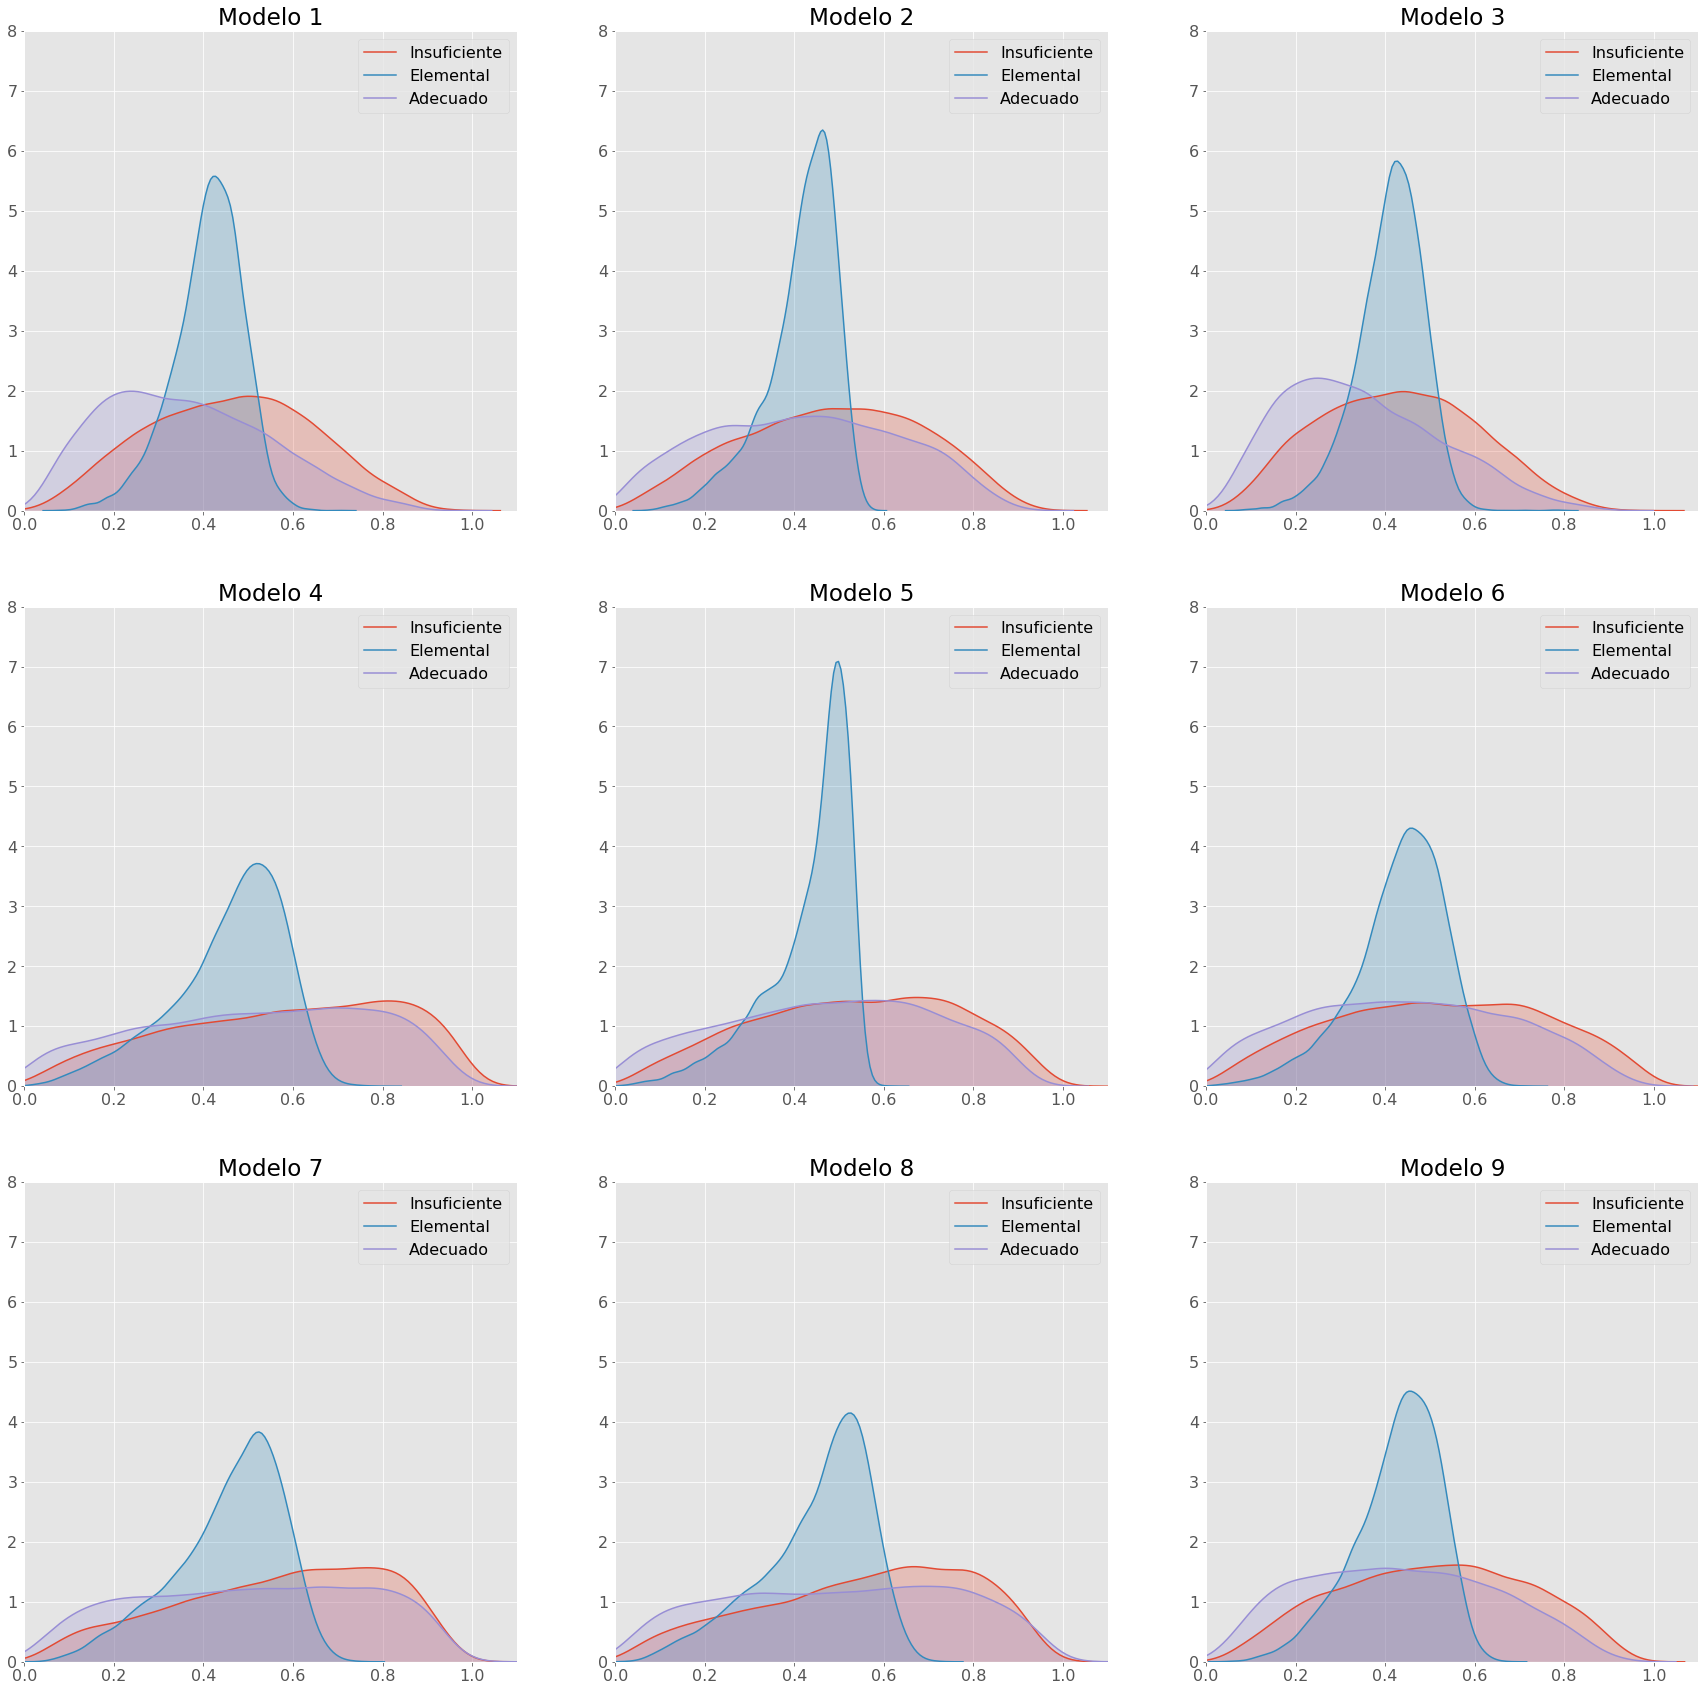

In [125]:
fig, axs = plt.subplots(3, 3, figsize=(30,30))

for clm, df_test in df_t_m1.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][0])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][0])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][0])        
for clm, df_test in df_t_m2.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][1])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][1])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][1])        
for clm, df_test in df_t_m3.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][2])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][2])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][2])
        
        
for clm, df_test in df_t_m4.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][0])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][0])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][0])
for clm, df_test in df_t_m5.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][1])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][1])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][1])        
for clm, df_test in df_t_m6.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][2])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][2])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][2])
        

for clm, df_test in df_t_m7.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][0])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][0])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][0])
for clm, df_test in df_t_m8.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][1])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][1])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][1])        
for clm, df_test in df_t_m9.groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][2])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][2])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][2])
        
c = 1    
for i in range(3):
    for k in range(3):
        axs[i][k].set(xlim=(0, 1.1), ylim=(0, 8))
        axs[i][k].set_title("Modelo "+str(c))
        c+=1
        
plt.savefig('all-models-density-by-class.pdf', bbox_inches='tight') 

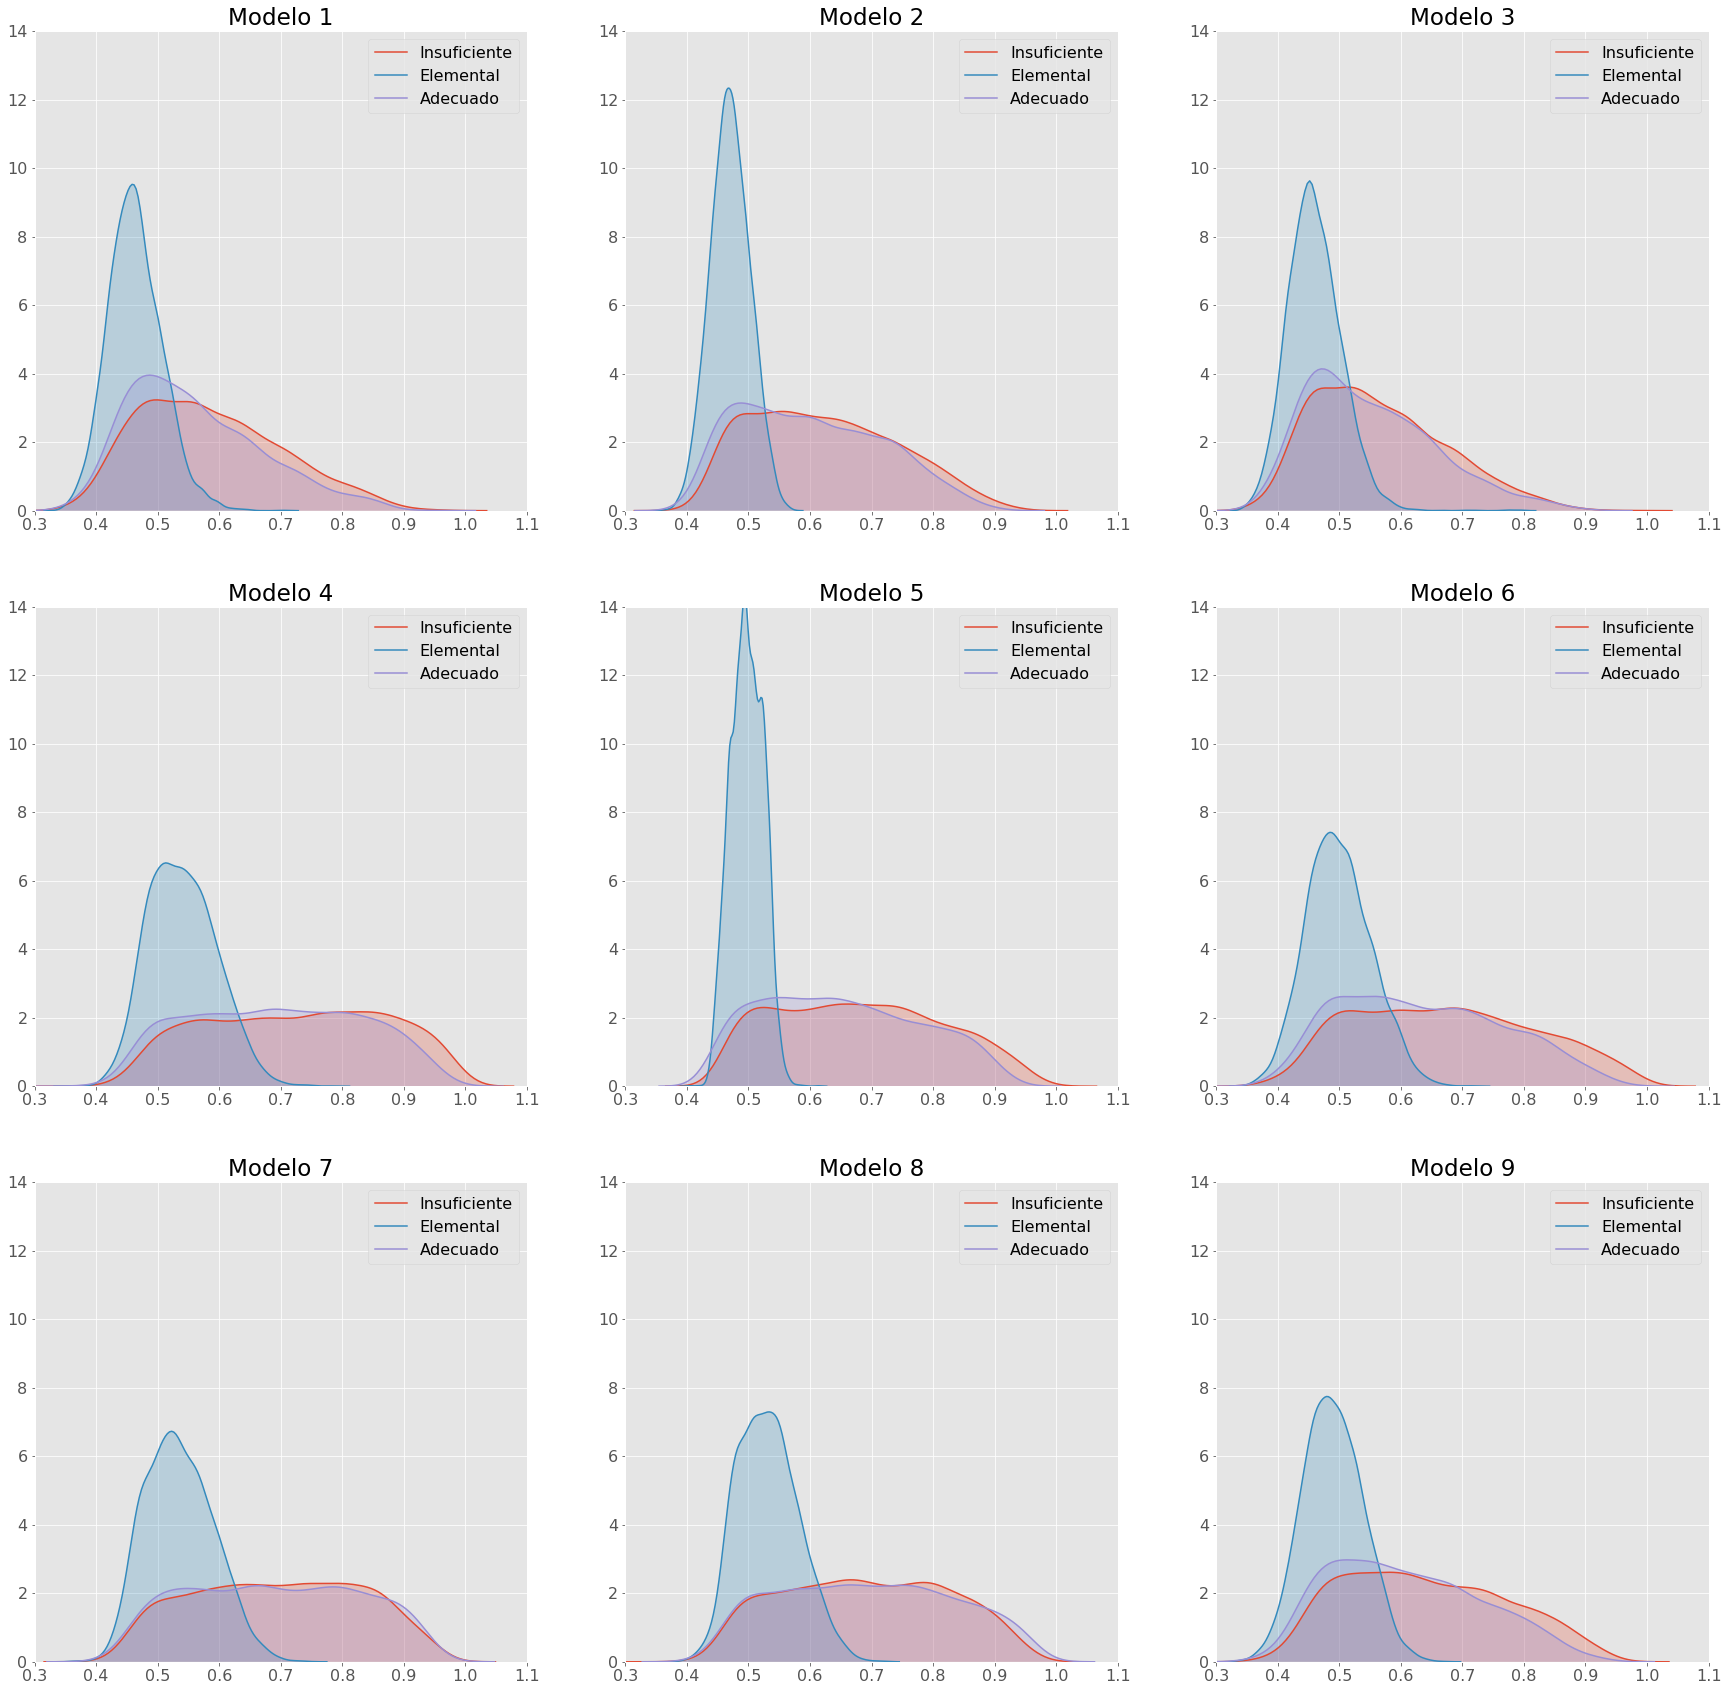

In [126]:
fig, axs = plt.subplots(3, 3, figsize=(30,30))

for clm, df_test in df_t_m1[df_t_m1['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][0])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][0])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][0])        
for clm, df_test in df_t_m2[df_t_m2['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][1])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][1])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][1])        
for clm, df_test in df_t_m3[df_t_m3['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][2])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][2])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[0][2])
        
        
for clm, df_test in df_t_m4[df_t_m4['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][0])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][0])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][0])
for clm, df_test in df_t_m5[df_t_m5['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][1])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][1])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][1])        
for clm, df_test in df_t_m6[df_t_m6['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][2])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][2])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[1][2])
        

for clm, df_test in df_t_m7[df_t_m7['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][0])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][0])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][0])
for clm, df_test in df_t_m8[df_t_m8['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][1])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][1])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][1])        
for clm, df_test in df_t_m9[df_t_m9['correct'] == 1].groupby('class'):
    if(int(clm) == 0):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][2])
    if(int(clm) == 1):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][2])
    if(int(clm) == 2):
        sns.kdeplot(df_test[target_names[int(clm)]], shade=True, label=target_names[int(clm)], ax=axs[2][2])
        
c = 1    
for i in range(3):
    for k in range(3):
        axs[i][k].set(xlim=(0.3, 1.1), ylim=(0, 14))
        axs[i][k].set_title("Modelo "+str(c))
        c+=1
        
plt.savefig('all-models-density-by-class-only-correct.pdf', bbox_inches='tight') 

In [129]:
for i in range(len(data_global)):
    print()

[0.5070283036836692, 0.5212952380952381, 0.512, 0.5199619047619047, 0.5152]

In [132]:
import statistics

In [138]:
for i in range(len(data_global)):
    print("Modelo", i+1)
    print(np.std(data_global[i][0]))
    print(np.mean(data_global[i][0]))

Modelo 1
0.005230513015621975
0.5150970893081624
Modelo 2
0.0040941823191039005
0.5427691631883411
Modelo 3
0.00441967897680709
0.4965677074252047
Modelo 4
0.0023603553032662335
0.6177171750373229
Modelo 5
0.002614187181010657
0.5885517216759089
Modelo 6
0.003556585278782844
0.5671118784046323
Modelo 7
0.0040212760504174765
0.6238961500967763
Modelo 8
0.0018172328640582516
0.6129248640323907
Modelo 9
0.0017208760073114963
0.5692528116298516


In [140]:
data_global[i][1][0]

{'Insuficiente': {'precision': 0.6389046056353966,
  'recall': 0.6155691234191016,
  'f1-score': 0.6270198234216225,
  'support': 9172},
 'Elemental': {'precision': 0.4941274468971262,
  'recall': 0.5734725444702243,
  'f1-score': 0.5308514922367892,
  'support': 10344},
 'Adecuado': {'precision': 0.6184137548530227,
  'recall': 0.49665924276169265,
  'f1-score': 0.5508893280632412,
  'support': 6735},
 'accuracy': 0.5684735819587825,
 'macro avg': {'precision': 0.5838152691285151,
  'recall': 0.5619003035503396,
  'f1-score': 0.569586881240551,
  'support': 26251},
 'weighted avg': {'precision': 0.576599138795735,
  'recall': 0.5684735819587825,
  'f1-score': 0.5695932833273551,
  'support': 26251}}

In [173]:
for i in range(len(data_global)):
    p = []
    r = []
    f = []
    for k in range(len(data_global[i][1])):
        p.append(data_global[i][1][k]['macro avg']['precision'])
        r.append(data_global[i][1][k]['macro avg']['recall'])
        f.append(data_global[i][1][k]['macro avg']['f1-score'])
    print("Modelo", i+1)
    print("accuracy: ", round(np.mean(data_global[i][0]),3), "( +-", round(np.std(data_global[i][0]), 4),")")
    print("precision: ", round(np.mean(p),3), "( +-", round(np.std(p), 4),")")
    print("recall: ", round(np.mean(r),3), "( +-", round(np.std(r), 4),")")
    print("f1 score: ", round(np.mean(f),3), "( +-", round(np.std(f), 4),")")
    print(
        "Modelo", i+1, " & ", 
        round(np.mean(data_global[i][0]),2), "\pm (", round(np.std(data_global[i][0]), 3),") &",
        round(np.mean(p),2), "\pm (", round(np.std(p), 3),") &",
        round(np.mean(r),2), "\pm (", round(np.std(r), 3),") &",
        round(np.mean(f),2), "\pm (", round(np.std(r), 3),") \\"
         )

Modelo 1  &  0.52 \pm ( 0.005 ) & 0.52 \pm ( 0.008 ) & 0.5 \pm ( 0.005 ) & 0.51 \pm ( 0.005 ) \
Modelo 2  &  0.54 \pm ( 0.004 ) & 0.55 \pm ( 0.004 ) & 0.54 \pm ( 0.005 ) & 0.54 \pm ( 0.005 ) \
Modelo 3  &  0.5 \pm ( 0.004 ) & 0.51 \pm ( 0.004 ) & 0.48 \pm ( 0.006 ) & 0.49 \pm ( 0.006 ) \
Modelo 4  &  0.62 \pm ( 0.002 ) & 0.63 \pm ( 0.002 ) & 0.62 \pm ( 0.003 ) & 0.62 \pm ( 0.003 ) \
Modelo 5  &  0.59 \pm ( 0.003 ) & 0.6 \pm ( 0.003 ) & 0.59 \pm ( 0.002 ) & 0.59 \pm ( 0.002 ) \
Modelo 6  &  0.57 \pm ( 0.004 ) & 0.58 \pm ( 0.004 ) & 0.56 \pm ( 0.003 ) & 0.57 \pm ( 0.003 ) \
Modelo 7  &  0.62 \pm ( 0.004 ) & 0.64 \pm ( 0.004 ) & 0.62 \pm ( 0.004 ) & 0.63 \pm ( 0.004 ) \
Modelo 8  &  0.61 \pm ( 0.002 ) & 0.63 \pm ( 0.002 ) & 0.61 \pm ( 0.002 ) & 0.62 \pm ( 0.002 ) \
Modelo 9  &  0.57 \pm ( 0.002 ) & 0.58 \pm ( 0.002 ) & 0.56 \pm ( 0.002 ) & 0.57 \pm ( 0.002 ) \


In [193]:
for i in range(len(data_global)):
    c1 = []
    c2 = []
    c3 = []
    micro = []
    macro = []
    for k in range(len(data_global[i][3])):
        c1.append(data_global[i][3][k][0])
        c2.append(data_global[i][3][k][1])
        c3.append(data_global[i][3][k][2])
        micro.append(data_global[i][3][k]['micro'])
        macro.append(data_global[i][3][k]['macro'])
    print(
        "Modelo", i+1, " & ", 
        round(np.mean(micro),2), "\pm (", round(np.std(micro), 3),") &",
        round(np.mean(macro),2), "\pm (", round(np.std(macro), 3),") &",
        round(np.mean(c1),2), "\pm (", round(np.std(c1), 3),") &",
        round(np.mean(c2),2), "\pm (", round(np.std(c2), 3),") &",
        round(np.mean(c3),2), "\pm (", round(np.std(c3), 3),") \\"
         )

Modelo 1  &  0.72 \pm ( 0.007 ) & 0.7 \pm ( 0.007 ) & 0.76 \pm ( 0.008 ) & 0.59 \pm ( 0.005 ) & 0.74 \pm ( 0.008 ) \
Modelo 2  &  0.74 \pm ( 0.004 ) & 0.73 \pm ( 0.004 ) & 0.78 \pm ( 0.003 ) & 0.61 \pm ( 0.004 ) & 0.79 \pm ( 0.005 ) \
Modelo 3  &  0.7 \pm ( 0.005 ) & 0.68 \pm ( 0.006 ) & 0.72 \pm ( 0.006 ) & 0.58 \pm ( 0.006 ) & 0.73 \pm ( 0.006 ) \
Modelo 4  &  0.81 \pm ( 0.001 ) & 0.8 \pm ( 0.001 ) & 0.85 \pm ( 0.002 ) & 0.68 \pm ( 0.001 ) & 0.86 \pm ( 0.001 ) \
Modelo 5  &  0.79 \pm ( 0.001 ) & 0.77 \pm ( 0.001 ) & 0.82 \pm ( 0.002 ) & 0.65 \pm ( 0.001 ) & 0.84 \pm ( 0.002 ) \
Modelo 6  &  0.77 \pm ( 0.002 ) & 0.75 \pm ( 0.002 ) & 0.8 \pm ( 0.001 ) & 0.64 \pm ( 0.003 ) & 0.82 \pm ( 0.004 ) \
Modelo 7  &  0.82 \pm ( 0.002 ) & 0.81 \pm ( 0.002 ) & 0.86 \pm ( 0.001 ) & 0.69 \pm ( 0.003 ) & 0.87 \pm ( 0.002 ) \
Modelo 8  &  0.81 \pm ( 0.001 ) & 0.79 \pm ( 0.001 ) & 0.85 \pm ( 0.002 ) & 0.68 \pm ( 0.003 ) & 0.86 \pm ( 0.002 ) \
Modelo 9  &  0.77 \pm ( 0.002 ) & 0.76 \pm ( 0.002 ) & 0.81 